In [1]:
!git clone https://github.com/aytenaaser/Machine_Learning_DataOrbit.git

Cloning into 'Machine_Learning_DataOrbit'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 3), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 368.94 KiB | 5.68 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [26]:

# ============================
# 1) LOAD DATA
# ============================

df = pd.read_csv("/content/Machine_Learning_DataOrbit/data/healthcare_provider_features.csv")

df["PotentialFraud"] = (
    df["PotentialFraud"]
    .astype(str)
    .str.strip()
    .str.capitalize()         # ensures "yes" → "Yes"
    .map({"Yes": 1, "No": 0}) # final mapping
)
# Feature / label split
X = df.drop(["PotentialFraud", "Provider", "FirstClaimDate", "LastClaimDate"], axis=1)
y = df["PotentialFraud"]

# ============================
# 2) TRAIN-TEST SPLIT
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [27]:
# ======================================
# FIX: HANDLE MISSING VALUES (VERY IMPORTANT)
# ======================================
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)




In [30]:
"""
Healthcare Fraud Detection with Hyperparameter Tuning
Train/Val/Test (60/20/20), validation-based selection, final test evaluations for ALL models
WITH HYPERPARAMETER TUNING
"""

import os, time, json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# sklearn / imblearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

# ----------------------------
# 0) Load data & label mapping
# ----------------------------
df = pd.read_csv("/content/Machine_Learning_DataOrbit/data/healthcare_provider_features.csv")

df["PotentialFraud"] = (
    df["PotentialFraud"]
    .astype(str)
    .str.strip()
    .str.capitalize()
    .map({"Yes": 1, "No": 0})
)

# drop unlabeled if any
df = df.dropna(subset=["PotentialFraud"]).reset_index(drop=True)
df["PotentialFraud"] = df["PotentialFraud"].astype(int)

# drop identifiers/dates from features if present
drop_cols = [c for c in ["Provider", "FirstClaimDate", "LastClaimDate"] if c in df.columns]
X = df.drop(columns=drop_cols + ["PotentialFraud"], errors="ignore")
y = df["PotentialFraud"]

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(X.columns)}")
print(f"Class distribution: {y.value_counts().to_dict()}")
print(f"Fraud rate: {(y.mean()*100):.2f}%")

# ----------------------------
# 1) 60/20/20 split
# ----------------------------
# First split: train (60%) + temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)

# Second split: temp -> val (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("\n" + "="*60)
print("DATA SPLITS")
print("="*60)
print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train class distribution:", y_train.value_counts().to_dict())
print("Val class distribution:", y_val.value_counts().to_dict())
print("Test class distribution:", y_test.value_counts().to_dict())

# ----------------------------
# 2) Impute numeric missing values (median)
# ----------------------------
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print("\nMissing values after imputation:")
print(f"Train: {X_train.isnull().sum().sum()}")
print(f"Val: {X_val.isnull().sum().sum()}")
print(f"Test: {X_test.isnull().sum().sum()}")

# ----------------------------
# 3) Strategy builder functions (UNCHANGED)
# ----------------------------
def build_class_weight_pipeline(clf_name):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    elif clf_name == "SVM":
        clf = SVC(class_weight="balanced", probability=True, random_state=42)
    else:
        return None
    steps = []
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", clf))
    return Pipeline(steps)

def build_smote_pipeline(clf_name):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(random_state=42)
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
    elif clf_name == "GradientBoosting":
        clf = GradientBoostingClassifier(random_state=42)
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(max_iter=1000, random_state=42)
    elif clf_name == "SVM":
        clf = SVC(probability=True, random_state=42)
    else:
        clf = None
    steps = [("smote", SMOTE(random_state=42))]
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.insert(0, ("scaler", StandardScaler()))
    steps.append(("clf", clf))
    return ImbPipeline(steps)

def build_undersample_pipeline(clf_name):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(random_state=42)
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
    elif clf_name == "GradientBoosting":
        clf = GradientBoostingClassifier(random_state=42)
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(max_iter=1000, random_state=42)
    elif clf_name == "SVM":
        clf = SVC(probability=True, random_state=42)
    else:
        clf = None
    steps = [("under", RandomUnderSampler(random_state=42))]
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.insert(0, ("scaler", StandardScaler()))
    steps.append(("clf", clf))
    return ImbPipeline(steps)

def build_cost_sensitive_pipeline(clf_name, cost_weights={0:1, 1:5}):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(class_weight=cost_weights, random_state=42)
        needs_sample_weight = False
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, class_weight=cost_weights, random_state=42)
        needs_sample_weight = False
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(class_weight=cost_weights, max_iter=1000, random_state=42)
        needs_sample_weight = False
    elif clf_name == "SVM":
        clf = SVC(class_weight=cost_weights, probability=True, random_state=42)
        needs_sample_weight = False
    else:
        clf = GradientBoostingClassifier(random_state=42)
        needs_sample_weight = True
    steps = []
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", clf))
    pipe = Pipeline(steps)
    return pipe, needs_sample_weight

# ----------------------------
# 4) HYPERPARAMETER TUNING FUNCTION
# ----------------------------
def tune_hyperparameters(clf_name, strategy, X_train, y_train, use_random_search=True):
    """
    Perform hyperparameter tuning for a given classifier and strategy
    """
    print(f"\n  Tuning {clf_name} with {strategy} strategy...")

    # Build base pipeline
    if strategy == 'class_weight':
        pipeline = build_class_weight_pipeline(clf_name)
    elif strategy == 'smote':
        pipeline = build_smote_pipeline(clf_name)
    elif strategy == 'undersample':
        pipeline = build_undersample_pipeline(clf_name)
    elif strategy == 'cost_sensitive':
        pipeline, _ = build_cost_sensitive_pipeline(clf_name)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    if pipeline is None:
        print(f"    Skipping {strategy} for {clf_name} (not supported)")
        return None, None, None

    # Define hyperparameter search spaces
    param_grids = {
        'DecisionTree': {
            'clf__max_depth': [5, 10, 15, 20, None],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__criterion': ['gini', 'entropy'],
            'clf__class_weight': ['balanced', None] if strategy == 'class_weight' else [None]
        },
        'RandomForest': {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [10, 20, 30, None],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__class_weight': ['balanced', None] if strategy == 'class_weight' else [None]
        },
        'GradientBoosting': {
            'clf__n_estimators': [100, 200, 300],
            'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'clf__max_depth': [3, 5, 7],
            'clf__subsample': [0.8, 0.9, 1.0],
            'clf__min_samples_split': [2, 5, 10]
        },
        'LogisticRegression': {
            'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga'],
            'clf__class_weight': ['balanced', None] if strategy == 'class_weight' else [None]
        },
        'SVM': {
            'clf__C': [0.1, 1, 10, 100],
            'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'clf__kernel': ['rbf', 'linear'],
            'clf__class_weight': ['balanced', None] if strategy == 'class_weight' else [None]
        }
    }

    # Get parameter grid for this classifier
    param_grid = param_grids.get(clf_name, {})

    # Adjust for cost-sensitive learning
    if strategy == 'cost_sensitive' and clf_name != 'GradientBoosting':
        param_grid['clf__class_weight'] = [{0:1, 1:3}, {0:1, 1:5}, {0:1, 1:10}]

    # Create cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use PR-AUC as scoring metric (your priority)
    scoring = 'average_precision'

    if use_random_search:
        # Use RandomizedSearchCV for faster exploration
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=20,  # Number of random combinations to try
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
    else:
        # Use GridSearchCV for exhaustive search (slower)
        search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=0
        )

    # Perform the search
    start_time = time.time()
    search.fit(X_train, y_train)
    tuning_time = time.time() - start_time

    print(f"    Best CV {scoring}: {search.best_score_:.4f}")
    print(f"    Best parameters: {search.best_params_}")
    print(f"    Tuning time: {tuning_time:.1f}s")

    return search.best_estimator_, search.best_params_, search.best_score_

# ----------------------------
# 5) Safe prob extraction and evaluation helper (UNCHANGED)
# ----------------------------
def safe_get_prob(model, X):
    if hasattr(model, "predict_proba"):
        try:
            return model.predict_proba(X)[:,1]
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            vals = model.decision_function(X)
            return np.ravel(vals)
        except Exception:
            pass
    return None

def evaluate_model_metrics(name, model, X_eval, y_eval, dataset_type="val"):
    y_pred = model.predict(X_eval)
    y_prob = safe_get_prob(model, X_eval)

    prec = precision_score(y_eval, y_pred, zero_division=0)
    rec = recall_score(y_eval, y_pred, zero_division=0)
    f1 = f1_score(y_eval, y_pred, zero_division=0)

    cm = confusion_matrix(y_eval, y_pred)
    tn = fp = fn = tp = None
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()

    pr_auc = None
    roc_auc = None
    if y_prob is not None:
        try:
            pr_auc = float(average_precision_score(y_eval, y_prob))
        except Exception:
            pr_auc = None
        try:
            # roc_auc_score requires both classes present in y_eval; wrap in try
            roc_auc = float(roc_auc_score(y_eval, y_prob))
        except Exception:
            roc_auc = None

    return {
        "model": name,
        "dataset": dataset_type,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "tp": int(tp) if tp is not None else None,
        "fp": int(fp) if fp is not None else None,
        "tn": int(tn) if tn is not None else None,
        "fn": int(fn) if fn is not None else None
    }

# ----------------------------
# 6) MAIN HYPERPARAMETER TUNING EXPERIMENT
# ----------------------------
classifier_names = ["DecisionTree", "RandomForest", "GradientBoosting", "LogisticRegression", "SVM"]
strategies = ["class_weight", "smote", "undersample", "cost_sensitive"]
results = []
tuned_models = {}  # Store tuned models for later use

print("\n" + "="*60)
print("HYPERPARAMETER TUNING ON TRAINING SET")
print("="*60)
print(f"Classifiers: {classifier_names}")
print(f"Strategies: {strategies}")
print(f"Using RandomizedSearchCV for faster exploration")
print(f"Scoring metric: average_precision (PR-AUC)")

# Use RandomizedSearchCV for speed (set to False for exhaustive GridSearchCV)
use_random_search = True

for clf_name in classifier_names:
    print(f"\n{'='*40}")
    print(f"TUNING {clf_name}")
    print(f"{'='*40}")

    for strategy in strategies:
        # Skip unsupported combinations
        if strategy == 'class_weight' and clf_name == 'GradientBoosting':
            print(f"  Skipping {strategy} for {clf_name} (not supported)")
            continue

        # Perform hyperparameter tuning
        best_model, best_params, best_cv_score = tune_hyperparameters(
            clf_name, strategy, X_train, y_train, use_random_search=use_random_search
        )

        if best_model is not None:
            # Evaluate tuned model on validation set
            val_metrics = evaluate_model_metrics(
                f"{clf_name}__{strategy}__TUNED",
                best_model,
                X_val,
                y_val,
                "val"
            )

            # Add tuning information
            val_metrics['best_params'] = str(best_params)
            val_metrics['best_cv_score'] = float(best_cv_score)
            results.append(val_metrics)

            # Store the tuned model
            tuned_models[f"{clf_name}__{strategy}"] = {
                'model': best_model,
                'params': best_params,
                'cv_score': best_cv_score,
                'val_metrics': val_metrics
            }

            print(f"  Validation PR-AUC: {val_metrics['pr_auc']:.4f}")

# ----------------------------
# 7) SELECT BEST TUNED MODEL
# ----------------------------
print("\n" + "="*60)
print("SELECTING BEST TUNED MODEL")
print("="*60)

# Filter for tuned validation results
val_results_df = pd.DataFrame([r for r in results if r["dataset"]=="val" and "TUNED" in r["model"]])

if not val_results_df.empty and val_results_df["pr_auc"].notna().any():
    # Sort by PR-AUC (your priority)
    val_results_df = val_results_df.sort_values(by="pr_auc", ascending=False)

    # Get best model info
    best_idx = val_results_df["pr_auc"].idxmax()
    best_info = val_results_df.loc[best_idx]

    # Extract base model name
    base_model_name = best_info['model'].replace('__TUNED', '')
    best_tuned_info = tuned_models.get(base_model_name)

    print(f"🏆 BEST TUNED MODEL: {best_info['model']}")
    print(f"   Validation PR-AUC: {best_info['pr_auc']:.4f}")
    print(f"   Cross-Validation PR-AUC: {best_info['best_cv_score']:.4f}")
    print(f"   Validation Recall: {best_info['recall']:.4f}")
    print(f"   Validation Precision: {best_info['precision']:.4f}")

    if best_tuned_info:
        print(f"\n📊 Best Parameters:")
        for param, value in best_tuned_info['params'].items():
            print(f"   {param}: {value}")
else:
    print("No valid tuned models found on validation set.")
    best_info = None
    best_tuned_info = None

# ----------------------------
# 8) RETRAIN AND EVALUATE BEST MODEL ON FULL TRAINING DATA
# ----------------------------
print("\n" + "="*60)
print("FINAL MODEL TRAINING AND EVALUATION")
print("="*60)

# Combine train+val for final training
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Final training data shape: {X_train_val.shape}")
print(f"Final class distribution: {y_train_val.value_counts().to_dict()}")

if best_info is not None and best_tuned_info is not None:
    # Extract classifier and strategy from model name
    model_parts = base_model_name.split('__')
    clf_name = model_parts[0]
    strategy = model_parts[1] if len(model_parts) > 1 else ""

    print(f"\nRetraining best model ({base_model_name}) on full training data...")

    # Get best parameters
    best_params = best_tuned_info['params']

    # Build pipeline with best parameters
    if strategy == 'class_weight':
        pipeline = build_class_weight_pipeline(clf_name)
    elif strategy == 'smote':
        pipeline = build_smote_pipeline(clf_name)
    elif strategy == 'undersample':
        pipeline = build_undersample_pipeline(clf_name)
    elif strategy == 'cost_sensitive':
        pipeline, _ = build_cost_sensitive_pipeline(clf_name)

    if pipeline is not None:
        # Set the best parameters
        pipeline.set_params(**best_params)

        # Fit on combined training data
        pipeline.fit(X_train_val, y_train_val)

        # Evaluate on test set
        final_test_metrics = evaluate_model_metrics(
            f"{best_info['model']}__FINAL",
            pipeline,
            X_test,
            y_test,
            "test"
        )
        results.append(final_test_metrics)

        print(f"\n📈 FINAL TEST PERFORMANCE:")
        print(f"   PR-AUC: {final_test_metrics['pr_auc']:.4f}")
        print(f"   ROC-AUC: {final_test_metrics['roc_auc']:.4f}")
        print(f"   Precision: {final_test_metrics['precision']:.4f}")
        print(f"   Recall: {final_test_metrics['recall']:.4f}")
        print(f"   F1-Score: {final_test_metrics['f1']:.4f}")

        # Confusion matrix details
        if final_test_metrics['tp'] is not None:
            print(f"\n🎯 CONFUSION MATRIX (Test Set):")
            print(f"   True Positives (Fraud caught): {final_test_metrics['tp']}")
            print(f"   False Positives (False alarms): {final_test_metrics['fp']}")
            print(f"   True Negatives (Legitimate correctly identified): {final_test_metrics['tn']}")
            print(f"   False Negatives (Fraud missed): {final_test_metrics['fn']}")

            # Calculate detection rates
            total_fraud = final_test_metrics['tp'] + final_test_metrics['fn']
            fraud_detection_rate = final_test_metrics['tp'] / total_fraud if total_fraud > 0 else 0
            print(f"   Fraud Detection Rate: {fraud_detection_rate:.2%}")

        # Save the final model
        import joblib
        model_path = "/content/Machine_Learning_DataOrbit/best_tuned_model.pkl"
        joblib.dump(pipeline, model_path)
        print(f"\n💾 Final model saved to: {model_path}")

        # Save tuning summary
        tuning_summary = {
            'best_model': best_info['model'],
            'best_parameters': best_params,
            'validation_performance': {
                'pr_auc': float(best_info['pr_auc']),
                'recall': float(best_info['recall']),
                'precision': float(best_info['precision']),
                'f1': float(best_info['f1'])
            },
            'test_performance': {
                'pr_auc': float(final_test_metrics['pr_auc']),
                'recall': float(final_test_metrics['recall']),
                'precision': float(final_test_metrics['precision']),
                'f1': float(final_test_metrics['f1'])
            },
            'data_info': {
                'train_samples': len(X_train),
                'val_samples': len(X_val),
                'test_samples': len(X_test),
                'total_samples': len(X),
                'fraud_rate': float(y.mean())
            }
        }

        summary_path = "/content/Machine_Learning_DataOrbit/reports/tuning_summary.json"
        with open(summary_path, 'w') as f:
            json.dump(tuning_summary, f, indent=2)
        print(f"📄 Tuning summary saved to: {summary_path}")

# ----------------------------
# 9) EVALUATE ALL TUNED MODELS ON TEST SET (OPTIONAL)
# ----------------------------
print("\n" + "="*60)
print("EVALUATING ALL TUNED MODELS ON TEST SET")
print("="*60)

test_results = []
for model_key, model_info in tuned_models.items():
    # Retrain each tuned model on full training data
    model_parts = model_key.split('__')
    clf_name = model_parts[0]
    strategy = model_parts[1] if len(model_parts) > 1 else ""

    # Build pipeline
    if strategy == 'class_weight':
        pipeline = build_class_weight_pipeline(clf_name)
    elif strategy == 'smote':
        pipeline = build_smote_pipeline(clf_name)
    elif strategy == 'undersample':
        pipeline = build_undersample_pipeline(clf_name)
    elif strategy == 'cost_sensitive':
        pipeline, _ = build_cost_sensitive_pipeline(clf_name)

    if pipeline is not None:
        # Set best parameters
        pipeline.set_params(**model_info['params'])

        # Fit on full training data
        pipeline.fit(X_train_val, y_train_val)

        # Evaluate on test set
        test_metrics = evaluate_model_metrics(
            f"{model_key}__TUNED__TEST",
            pipeline,
            X_test,
            y_test,
            "test"
        )
        test_results.append(test_metrics)
        print(f"✓ {model_key}: PR-AUC = {test_metrics['pr_auc']:.4f}, Recall = {test_metrics['recall']:.4f}")

# Add test results to main results
results.extend(test_results)

# ----------------------------
# 10) BUILD FINAL SUMMARY AND SAVE RESULTS
# ----------------------------
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

# Build summary DataFrame
summary_df = pd.DataFrame(results)
cols = ["model", "dataset", "pr_auc", "roc_auc", "precision", "recall", "f1", "tp", "fp", "tn", "fn", "best_cv_score", "best_params"]
for c in cols:
    if c not in summary_df.columns:
        summary_df[c] = None

# Ensure columns in right order
summary_df = summary_df[cols]

# Display validation results
print("\nVALIDATION RESULTS (Tuned Models - Sorted by PR-AUC):")
val_summary = summary_df[summary_df["dataset"]=="val"].sort_values(by="pr_auc", ascending=False, na_position="last")
print(val_summary[['model', 'pr_auc', 'recall', 'precision', 'f1', 'best_cv_score']].head(10).to_string(index=False))

# Display test results
print("\n\nTEST RESULTS (All Tuned Models - Sorted by PR-AUC):")
test_summary = summary_df[summary_df["dataset"]=="test"].sort_values(by="pr_auc", ascending=False, na_position="last")
print(test_summary[['model', 'pr_auc', 'recall', 'precision', 'f1']].head(15).to_string(index=False))

# Save comprehensive results
results_path = "/content/Machine_Learning_DataOrbit/reports/hyperparameter_tuning_results_full.csv"
summary_df.to_csv(results_path, index=False)

# Save top models comparison
top_models = test_summary.head(10)[['model', 'pr_auc', 'recall', 'precision', 'f1']]
top_models_path = "/content/Machine_Learning_DataOrbit/reports/top_tuned_models.csv"
top_models.to_csv(top_models_path, index=False)

print(f"\n✅ Results saved to:")
print(f"   Full results: {results_path}")
print(f"   Top models: {top_models_path}")

# ----------------------------
# 11) VISUALIZE RESULTS
# ----------------------------
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)

    # Plot 1: Top 10 models by PR-AUC
    plt.figure(figsize=(12, 6))

    # Get top 10 test models
    top_10 = test_summary.head(10).copy()
    top_10['model_short'] = top_10['model'].str.replace('__TUNED__TEST', '').str.replace('__FINAL', '')

    # Create grouped bar chart
    x = range(len(top_10))
    width = 0.25

    plt.bar([i - width for i in x], top_10['pr_auc'], width, label='PR-AUC', color='steelblue', alpha=0.8)
    plt.bar(x, top_10['recall'], width, label='Recall', color='coral', alpha=0.8)
    plt.bar([i + width for i in x], top_10['precision'], width, label='Precision', color='seagreen', alpha=0.8)

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Top 10 Tuned Models - Performance Comparison')
    plt.xticks(x, top_10['model_short'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    # Save plot
    plot_path = "/content/Machine_Learning_DataOrbit/reports/top_models_comparison.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"📊 Visualization saved to: {plot_path}")
    plt.show()

    # Plot 2: PR-AUC vs Recall scatter
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(test_summary['recall'], test_summary['pr_auc'],
                         c=test_summary['f1'], cmap='viridis', s=100, alpha=0.7)

    # Highlight best model
    if not test_summary.empty:
        best_model_idx = test_summary['pr_auc'].idxmax()
        plt.scatter(test_summary.loc[best_model_idx, 'recall'],
                   test_summary.loc[best_model_idx, 'pr_auc'],
                   s=200, c='red', marker='*', label='Best Model')

    plt.xlabel('Recall')
    plt.ylabel('PR-AUC')
    plt.title('PR-AUC vs Recall (Color = F1-Score)')
    plt.colorbar(scatter, label='F1-Score')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    scatter_path = "/content/Machine_Learning_DataOrbit/reports/pr_auc_vs_recall.png"
    plt.savefig(scatter_path, dpi=150, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Visualization failed (matplotlib/seaborn not available or error): {e}")

print("\n" + "="*60)
print("HYPERPARAMETER TUNING COMPLETE! ✅")
print("="*60)
print("\nNext steps:")
print("1. Check the saved model at: /content/Machine_Learning_DataOrbit/models/best_tuned_model.pkl")
print("2. Review tuning summary at: /content/Machine_Learning_DataOrbit/reports/tuning_summary.json")
print("3. Compare all models in: /content/Machine_Learning_DataOrbit/reports/hyperparameter_tuning_results_full.csv")
print("\nThe tuned model should have better performance than untuned versions!")

Dataset shape: (5410, 25)
Features: 21
Class distribution: {0: 4904, 1: 506}
Fraud rate: 9.35%

DATA SPLITS
Shapes -> Train: (3246, 21) Val: (1082, 21) Test: (1082, 21)
Train class distribution: {0: 2942, 1: 304}
Val class distribution: {0: 981, 1: 101}
Test class distribution: {0: 981, 1: 101}

Missing values after imputation:
Train: 0
Val: 0
Test: 0

HYPERPARAMETER TUNING ON TRAINING SET
Classifiers: ['DecisionTree', 'RandomForest', 'GradientBoosting', 'LogisticRegression', 'SVM']
Strategies: ['class_weight', 'smote', 'undersample', 'cost_sensitive']
Using RandomizedSearchCV for faster exploration
Scoring metric: average_precision (PR-AUC)

TUNING DecisionTree

  Tuning DecisionTree with class_weight strategy...
    Best CV average_precision: 0.6006
    Best parameters: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 5, 'clf__criterion': 'gini', 'clf__class_weight': None}
    Tuning time: 10.4s
  Validation PR-AUC: 0.6675

  Tuning DecisionTree with smote 

FileNotFoundError: [Errno 2] No such file or directory: '/content/Machine_Learning_DataOrbit/models/best_tuned_model.pkl'

In [29]:
# ----------------------------
# 0) Load data & label mapping
# ----------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
import numpy as np

df = pd.read_csv("/content/Machine_Learning_DataOrbit/data/healthcare_provider_features.csv")

df["PotentialFraud"] = (
    df["PotentialFraud"]
    .astype(str)
    .str.strip()
    .str.capitalize()
    .map({"Yes": 1, "No": 0})
)

df = df.dropna(subset=["PotentialFraud"]).reset_index(drop=True)
df["PotentialFraud"] = df["PotentialFraud"].astype(int)

drop_cols = [c for c in ["Provider", "FirstClaimDate", "LastClaimDate"] if c in df.columns]
X = df.drop(columns=drop_cols + ["PotentialFraud"], errors="ignore")
y = df["PotentialFraud"]

# ----------------------------
# 1) 60/20/20 split
# ----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ----------------------------
# 2) Impute numeric missing values (median)
# ----------------------------
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# ----------------------------
# 3) Strategy builder functions for RandomForest only
# ----------------------------
def build_randomforest_class_weight():
    """RandomForest with class_weight='balanced'"""
    clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    return Pipeline([("clf", clf)])

def build_randomforest_smote():
    """RandomForest with SMOTE oversampling"""
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    return ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])

def build_randomforest_undersample():
    """RandomForest with random undersampling"""
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    return ImbPipeline([
        ("under", RandomUnderSampler(random_state=42)),
        ("clf", clf)
    ])

def build_randomforest_cost_sensitive(cost_weights={0:1, 1:5}):
    """RandomForest with cost-sensitive class weights"""
    clf = RandomForestClassifier(n_estimators=200, class_weight=cost_weights, random_state=42)
    return Pipeline([("clf", clf)]), False  # False = doesn't need sample_weight

# ----------------------------
# 4) Evaluation helper
# ----------------------------
def evaluate_model_metrics(name, model, X_eval, y_eval, dataset_type="val"):
    y_pred = model.predict(X_eval)

    # Get probabilities if available
    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_eval)[:,1]
        except:
            pass

    # Calculate metrics
    prec = precision_score(y_eval, y_pred, zero_division=0)
    rec = recall_score(y_eval, y_pred, zero_division=0)
    f1 = f1_score(y_eval, y_pred, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # PR-AUC and ROC-AUC
    pr_auc = None
    roc_auc = None
    if y_prob is not None:
        try:
            pr_auc = float(average_precision_score(y_eval, y_prob))
        except:
            pass
        try:
            roc_auc = float(roc_auc_score(y_eval, y_prob))
        except:
            pass

    return {
        "model": name,
        "dataset": dataset_type,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "tp": int(tp),
        "fp": int(fp),
        "tn": int(tn),
        "fn": int(fn)
    }

# ----------------------------
# 5) Train and evaluate all RandomForest strategies on VALIDATION
# ----------------------------
print("\n=== RANDOM FOREST WITH DIFFERENT STRATEGIES ===")
print("Training on TRAIN set, evaluating on VALIDATION set\n")

results = []
cost_weights = {0:1, 1:5}

# 1) class_weight strategy
print("1. RandomForest with class_weight='balanced'")
rf_cw = build_randomforest_class_weight()
rf_cw.fit(X_train, y_train)
results.append(evaluate_model_metrics("RandomForest__class_weight", rf_cw, X_val, y_val, "val"))

# 2) SMOTE strategy
print("2. RandomForest with SMOTE oversampling")
rf_smote = build_randomforest_smote()
rf_smote.fit(X_train, y_train)
results.append(evaluate_model_metrics("RandomForest__smote", rf_smote, X_val, y_val, "val"))

# 3) undersample strategy
print("3. RandomForest with random undersampling")
rf_under = build_randomforest_undersample()
rf_under.fit(X_train, y_train)
results.append(evaluate_model_metrics("RandomForest__undersample", rf_under, X_val, y_val, "val"))

# 4) cost_sensitive strategy
print("4. RandomForest with cost-sensitive weights (fraud 5x more important)")
rf_cost, _ = build_randomforest_cost_sensitive(cost_weights)
rf_cost.fit(X_train, y_train)
results.append(evaluate_model_metrics("RandomForest__cost_sensitive", rf_cost, X_val, y_val, "val"))

# ----------------------------
# 6) Display validation results
# ----------------------------
print("\n" + "="*80)
print("VALIDATION SET RESULTS (RandomForest only)")
print("="*80)

val_results_df = pd.DataFrame(results)
print(val_results_df[["model", "pr_auc", "precision", "recall", "f1", "tp", "fp", "tn", "fn"]])

# Find best by PR-AUC
if not val_results_df.empty and val_results_df["pr_auc"].notna().any():
    best_idx = val_results_df["pr_auc"].idxmax()
    best_model_info = val_results_df.loc[best_idx]
    print(f"\n🎯 Best RandomForest strategy on validation: {best_model_info['model']}")
    print(f"   PR-AUC: {best_model_info['pr_auc']:.4f}, Recall: {best_model_info['recall']:.4f}")

# ----------------------------
# 7) Retrain best model on TRAIN+VAL and test on TEST
# ----------------------------
print("\n" + "="*80)
print("RETRAINING BEST MODEL ON TRAIN+VAL AND TESTING")
print("="*80)

# Combine train+val
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Retrain all strategies on combined data and test
final_results = []

strategies = [
    ("RandomForest__class_weight", build_randomforest_class_weight),
    ("RandomForest__smote", build_randomforest_smote),
    ("RandomForest__undersample", build_randomforest_undersample),
    ("RandomForest__cost_sensitive", lambda: build_randomforest_cost_sensitive(cost_weights)[0])
]

for name, builder_func in strategies:
    print(f"\nTesting {name} on TEST set:")

    # Build and train on train+val
    if "cost_sensitive" in name:
        model, _ = build_randomforest_cost_sensitive(cost_weights)
    else:
        model = builder_func()

    model.fit(X_train_val, y_train_val)

    # Evaluate on test
    test_result = evaluate_model_metrics(name, model, X_test, y_test, "test")
    final_results.append(test_result)

    # Print key metrics
    print(f"  PR-AUC: {test_result['pr_auc']:.4f}")
    print(f"  Recall: {test_result['recall']:.4f} (catches {test_result['recall']*100:.1f}% of fraud)")
    print(f"  Precision: {test_result['precision']:.4f} ({test_result['precision']*100:.1f}% of alarms are correct)")
    print(f"  False alarms: {test_result['fp']}, Missed fraud: {test_result['fn']}")

# ----------------------------
# 8) Final comparison
# ----------------------------
print("\n" + "="*80)
print("FINAL TEST SET COMPARISON")
print("="*80)

final_df = pd.DataFrame(final_results)
final_df = final_df.sort_values(by="pr_auc", ascending=False)

display(final_df[["model", "pr_auc", "precision", "recall", "f1", "tp", "fp", "tn", "fn"]])

print("\n📊 Summary:")
for _, row in final_df.iterrows():
    print(f"{row['model']}:")
    print(f"  • Catches {row['recall']*100:.1f}% of fraud ({row['tp']}/{row['tp']+row['fn']})")
    print(f"  • {row['precision']*100:.1f}% of fraud alarms are correct")
    print(f"  • {row['fp']} false alarms, {row['fn']} missed fraud cases")
    print()

# Save results
output_path = "/content/Machine_Learning_DataOrbit/reports/randomforest_comparison_results.csv"
final_df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")

Shapes -> Train: (3246, 21) Val: (1082, 21) Test: (1082, 21)

=== RANDOM FOREST WITH DIFFERENT STRATEGIES ===
Training on TRAIN set, evaluating on VALIDATION set

1. RandomForest with class_weight='balanced'
2. RandomForest with SMOTE oversampling
3. RandomForest with random undersampling
4. RandomForest with cost-sensitive weights (fraud 5x more important)

VALIDATION SET RESULTS (RandomForest only)
                          model    pr_auc  precision    recall        f1  tp  \
0    RandomForest__class_weight  0.722786   0.733333  0.544554  0.625000  55   
1           RandomForest__smote  0.683286   0.568000  0.702970  0.628319  71   
2     RandomForest__undersample  0.652302   0.386957  0.881188  0.537764  89   
3  RandomForest__cost_sensitive  0.728335   0.716216  0.524752  0.605714  53   

    fp   tn  fn  
0   20  961  46  
1   54  927  30  
2  141  840  12  
3   21  960  48  

🎯 Best RandomForest strategy on validation: RandomForest__cost_sensitive
   PR-AUC: 0.7283, Recall: 0.52

,model,pr_auc,precision,recall,f1,tp,fp,tn,fn
3,RandomForest__cost_sensitive,0.690618,0.736111,0.524752,0.612717,53,19,962,48
1,RandomForest__smote,0.673725,0.510345,0.732673,0.601626,74,71,910,27
0,RandomForest__class_weight,0.672313,0.708333,0.504950,0.589595,51,21,960,50
2,RandomForest__undersample,0.606491,0.358871,0.881188,0.510029,89,159,822,12



📊 Summary:
RandomForest__cost_sensitive:
  • Catches 52.5% of fraud (53/101)
  • 73.6% of fraud alarms are correct
  • 19 false alarms, 48 missed fraud cases

RandomForest__smote:
  • Catches 73.3% of fraud (74/101)
  • 51.0% of fraud alarms are correct
  • 71 false alarms, 27 missed fraud cases

RandomForest__class_weight:
  • Catches 50.5% of fraud (51/101)
  • 70.8% of fraud alarms are correct
  • 21 false alarms, 50 missed fraud cases

RandomForest__undersample:
  • Catches 88.1% of fraud (89/101)
  • 35.9% of fraud alarms are correct
  • 159 false alarms, 12 missed fraud cases

✅ Results saved to: /content/Machine_Learning_DataOrbit/reports/randomforest_comparison_results.csv


In [7]:
# Full experiment cell: train/val/test (60/20/20), validation-based selection, final test evaluations for ALL models
import os, time, json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# sklearn / imblearn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

# ----------------------------
# 0) Load data & label mapping
# ----------------------------
df = pd.read_csv("/content/Machine_Learning_DataOrbit/data/healthcare_provider_features.csv")

df["PotentialFraud"] = (
    df["PotentialFraud"]
    .astype(str)
    .str.strip()
    .str.capitalize()
    .map({"Yes": 1, "No": 0})
)

# drop unlabeled if any
df = df.dropna(subset=["PotentialFraud"]).reset_index(drop=True)
df["PotentialFraud"] = df["PotentialFraud"].astype(int)

# drop identifiers/dates from features if present
drop_cols = [c for c in ["Provider", "FirstClaimDate", "LastClaimDate"] if c in df.columns]
X = df.drop(columns=drop_cols + ["PotentialFraud"], errors="ignore")
y = df["PotentialFraud"]

# ----------------------------
# 1) 60/20/20 split
# ----------------------------
# First split: train (60%) + temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)

# Second split: temp -> val (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Class distribution - Train:", y_train.value_counts().to_dict(), "Val:", y_val.value_counts().to_dict(), "Test:", y_test.value_counts().to_dict())

# ----------------------------
# 2) Impute numeric missing values (median)
# ----------------------------
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# ----------------------------
# 3) Strategy builder functions
# ----------------------------
def build_class_weight_pipeline(clf_name):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    elif clf_name == "SVM":
        clf = SVC(class_weight="balanced", probability=True, random_state=42)
    else:
        return None
    steps = []
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", clf))
    return Pipeline(steps)

def build_smote_pipeline(clf_name):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(random_state=42)
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
    elif clf_name == "GradientBoosting":
        clf = GradientBoostingClassifier(random_state=42)
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(max_iter=1000, random_state=42)
    elif clf_name == "SVM":
        clf = SVC(probability=True, random_state=42)
    else:
        clf = None
    steps = [("smote", SMOTE(random_state=42))]
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.insert(0, ("scaler", StandardScaler()))
    steps.append(("clf", clf))
    return ImbPipeline(steps)

def build_undersample_pipeline(clf_name):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(random_state=42)
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
    elif clf_name == "GradientBoosting":
        clf = GradientBoostingClassifier(random_state=42)
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(max_iter=1000, random_state=42)
    elif clf_name == "SVM":
        clf = SVC(probability=True, random_state=42)
    else:
        clf = None
    steps = [("under", RandomUnderSampler(random_state=42))]
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.insert(0, ("scaler", StandardScaler()))
    steps.append(("clf", clf))
    return ImbPipeline(steps)

def build_cost_sensitive_pipeline(clf_name, cost_weights={0:1, 1:5}):
    if clf_name == "DecisionTree":
        clf = DecisionTreeClassifier(class_weight=cost_weights, random_state=42)
        needs_sample_weight = False
    elif clf_name == "RandomForest":
        clf = RandomForestClassifier(n_estimators=200, class_weight=cost_weights, random_state=42)
        needs_sample_weight = False
    elif clf_name == "LogisticRegression":
        clf = LogisticRegression(class_weight=cost_weights, max_iter=1000, random_state=42)
        needs_sample_weight = False
    elif clf_name == "SVM":
        clf = SVC(class_weight=cost_weights, probability=True, random_state=42)
        needs_sample_weight = False
    else:
        clf = GradientBoostingClassifier(random_state=42)
        needs_sample_weight = True
    steps = []
    if clf_name in ["LogisticRegression", "SVM"]:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", clf))
    pipe = Pipeline(steps)
    return pipe, needs_sample_weight

# ----------------------------
# 4) Safe prob extraction and evaluation helper
# ----------------------------
def safe_get_prob(model, X):
    if hasattr(model, "predict_proba"):
        try:
            return model.predict_proba(X)[:,1]
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            vals = model.decision_function(X)
            return np.ravel(vals)
        except Exception:
            pass
    return None

def evaluate_model_metrics(name, model, X_eval, y_eval, dataset_type="val"):
    y_pred = model.predict(X_eval)
    y_prob = safe_get_prob(model, X_eval)

    prec = precision_score(y_eval, y_pred, zero_division=0)
    rec = recall_score(y_eval, y_pred, zero_division=0)
    f1 = f1_score(y_eval, y_pred, zero_division=0)

    cm = confusion_matrix(y_eval, y_pred)
    tn = fp = fn = tp = None
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()

    pr_auc = None
    roc_auc = None
    if y_prob is not None:
        try:
            pr_auc = float(average_precision_score(y_eval, y_prob))
        except Exception:
            pr_auc = None
        try:
            # roc_auc_score requires both classes present in y_eval; wrap in try
            roc_auc = float(roc_auc_score(y_eval, y_prob))
        except Exception:
            roc_auc = None

    return {
        "model": name,
        "dataset": dataset_type,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "tp": int(tp) if tp is not None else None,
        "fp": int(fp) if fp is not None else None,
        "tn": int(tn) if tn is not None else None,
        "fn": int(fn) if fn is not None else None
    }
# ----------------------------
# 5) Run experiments: train on TRAIN, evaluate on VAL
# ----------------------------
classifier_names = ["DecisionTree", "RandomForest", "GradientBoosting", "LogisticRegression", "SVM"]
results = []
cost_weights = {0:1, 1:5}

print("\n=== TRAINING MODELS ON TRAIN SET, EVALUATING ON VALIDATION SET ===")
for clf_name in classifier_names:
    print(f"\n--- {clf_name} ---")
    # 1) class_weight
    cw = build_class_weight_pipeline(clf_name)
    if cw is not None:
        cw.fit(X_train, y_train)
        results.append(evaluate_model_metrics(f"{clf_name}__class_weight", cw, X_val, y_val, "val"))
        print(" class_weight done")
    else:
        base_pipe = Pipeline([("clf",
                               DecisionTreeClassifier(random_state=42) if clf_name=="DecisionTree" else
                               RandomForestClassifier(n_estimators=200, random_state=42) if clf_name=="RandomForest" else
                               GradientBoostingClassifier(random_state=42) if clf_name=="GradientBoosting" else
                               LogisticRegression(max_iter=1000, random_state=42) if clf_name=="LogisticRegression" else
                               SVC(probability=True, random_state=42)
                              )])
        base_pipe.fit(X_train, y_train)
        results.append(evaluate_model_metrics(f"{clf_name}__class_weight_NO_SUPPORT", base_pipe, X_val, y_val, "val"))
        print(" class_weight (fallback) done")

    # 2) SMOTE
    sm = build_smote_pipeline(clf_name)
    sm.fit(X_train, y_train)
    results.append(evaluate_model_metrics(f"{clf_name}__smote", sm, X_val, y_val, "val"))
    print(" smote done")

    # 3) undersample
    un = build_undersample_pipeline(clf_name)
    un.fit(X_train, y_train)
    results.append(evaluate_model_metrics(f"{clf_name}__undersample", un, X_val, y_val, "val"))
    print(" undersample done")

    # 4) cost-sensitive
    cp, needs_sw = build_cost_sensitive_pipeline(clf_name, cost_weights)
    if not needs_sw:
        cp.fit(X_train, y_train)
        results.append(evaluate_model_metrics(f"{clf_name}__cost_sensitive", cp, X_val, y_val, "val"))
        print(" cost_sensitive (constructor) done")
    else:
        sw = np.array([cost_weights[int(lbl)] for lbl in y_train])
        try:
            cp.fit(X_train, y_train, clf__sample_weight=sw)
            results.append(evaluate_model_metrics(f"{clf_name}__cost_sensitive_sample_weight", cp, X_val, y_val, "val"))
            print(" cost_sensitive (sample_weight) done")
        except Exception:
            cp.fit(X_train, y_train)
            results.append(evaluate_model_metrics(f"{clf_name}__cost_sensitive_NO_SUPPORT", cp, X_val, y_val, "val"))
            print(" cost_sensitive (fallback) done")

# ----------------------------
# 6) Select best by validation PR-AUC and retrain on TRAIN+VAL
# ----------------------------
val_results_df = pd.DataFrame([r for r in results if r["dataset"]=="val"])
best_info = None
if not val_results_df.empty and val_results_df["pr_auc"].notna().any():
    best_idx = val_results_df["pr_auc"].idxmax()
    best_info = val_results_df.loc[best_idx]
    print("\nBest on validation:", best_info["model"], "PR-AUC:", best_info["pr_auc"])
else:
    print("\nNo valid PR-AUC found on validation to select best model.")

# Combine train+val for final retraining stage
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Retrain best model on train+val
best_model_obj = None
if best_info is not None:
    best_name = best_info["model"]
    parts = best_name.split("__")
    clf_for_best = parts[0]
    strat_for_best = parts[1] if len(parts) > 1 else ""

    print("\nRetraining selected best model on train+val:", best_name)
    if "class_weight" in strat_for_best:
        best_model_obj = build_class_weight_pipeline(clf_for_best)
        if best_model_obj is not None:
            best_model_obj.fit(X_train_val, y_train_val)
    elif "smote" in strat_for_best:
        best_model_obj = build_smote_pipeline(clf_for_best)
        best_model_obj.fit(X_train_val, y_train_val)
    elif "undersample" in strat_for_best:
        best_model_obj = build_undersample_pipeline(clf_for_best)
        best_model_obj.fit(X_train_val, y_train_val)
    elif "cost_sensitive" in strat_for_best:
        best_model_obj, needs_sw = build_cost_sensitive_pipeline(clf_for_best, cost_weights)
        if needs_sw:
            sw_val = np.array([cost_weights[int(lbl)] for lbl in y_train_val])
            try:
                best_model_obj.fit(X_train_val, y_train_val, clf__sample_weight=sw_val)
            except Exception:
                best_model_obj.fit(X_train_val, y_train_val)
        else:
            best_model_obj.fit(X_train_val, y_train_val)

    # Evaluate selected best on test
    if best_model_obj is not None:
        final_test_res = evaluate_model_metrics(f"{best_name}__FINAL", best_model_obj, X_test, y_test, "test")
        results.append(final_test_res)
        print("\nFinal test evaluation for selected best:")
        print(final_test_res)

# ----------------------------
# 7) EVALUATE ALL MODELS (trained on TRAIN+VAL) ON THE TEST SET
# ----------------------------
print("\nEvaluating ALL model x strategy combos on TEST set (trained on train+val). This produces a test row for every combo.")

test_evals = []
for clf_name in classifier_names:
    # class_weight
    pipe = build_class_weight_pipeline(clf_name)
    if pipe is not None:
        pipe.fit(X_train_val, y_train_val)
        test_evals.append(evaluate_model_metrics(f"{clf_name}__class_weight", pipe, X_test, y_test, "test"))
    else:
        base_pipe = Pipeline([("clf",
                               DecisionTreeClassifier(random_state=42) if clf_name=="DecisionTree" else
                               RandomForestClassifier(n_estimators=200, random_state=42) if clf_name=="RandomForest" else
                               GradientBoostingClassifier(random_state=42) if clf_name=="GradientBoosting" else
                               LogisticRegression(max_iter=1000, random_state=42) if clf_name=="LogisticRegression" else
                               SVC(probability=True, random_state=42)
                              )])
        base_pipe.fit(X_train_val, y_train_val)
        test_evals.append(evaluate_model_metrics(f"{clf_name}__class_weight_NO_SUPPORT", base_pipe, X_test, y_test, "test"))

    # smote
    pipe = build_smote_pipeline(clf_name)
    pipe.fit(X_train_val, y_train_val)
    test_evals.append(evaluate_model_metrics(f"{clf_name}__smote", pipe, X_test, y_test, "test"))

    # undersample
    pipe = build_undersample_pipeline(clf_name)
    pipe.fit(X_train_val, y_train_val)
    test_evals.append(evaluate_model_metrics(f"{clf_name}__undersample", pipe, X_test, y_test, "test"))

    # cost_sensitive
    pipe, needs_sw = build_cost_sensitive_pipeline(clf_name, cost_weights)
    if needs_sw:
        sw_val = np.array([cost_weights[int(lbl)] for lbl in y_train_val])
        try:
            pipe.fit(X_train_val, y_train_val, clf__sample_weight=sw_val)
        except Exception:
            pipe.fit(X_train_val, y_train_val)
    else:
        pipe.fit(X_train_val, y_train_val)
    test_evals.append(evaluate_model_metrics(f"{clf_name}__cost_sensitive", pipe, X_test, y_test, "test"))

# append test evals to results
results.extend(test_evals)

# ----------------------------
# 8) Build summary DataFrame and save CSV
# ----------------------------
summary_df = pd.DataFrame(results)
cols = ["model", "dataset", "pr_auc","roc_auc", "precision", "recall", "f1", "tp", "fp", "tn", "fn"]
for c in cols:
    if c not in summary_df.columns:
        summary_df[c] = None
summary_df = summary_df[cols]

print("\nValidation results (sorted by pr_auc desc):")
val_summary = summary_df[summary_df["dataset"]=="val"].sort_values(by="pr_auc", ascending=False, na_position="last")
display(val_summary.reset_index(drop=True))

print("\nTest results (ALL combos) sorted by pr_auc desc:")
test_summary = summary_df[summary_df["dataset"]=="test"].sort_values(by="pr_auc", ascending=False, na_position="last")
display(test_summary.reset_index(drop=True))

# Save to CSV
out_path = "/content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv"
summary_df.to_csv(out_path, index=False)
print("\nSaved full results (validation + test rows) to:", out_path)

Shapes -> Train: (3246, 21) Val: (1082, 21) Test: (1082, 21)
Class distribution - Train: {0: 2942, 1: 304} Val: {0: 981, 1: 101} Test: {0: 981, 1: 101}

=== TRAINING MODELS ON TRAIN SET, EVALUATING ON VALIDATION SET ===

--- DecisionTree ---
 class_weight done
 smote done
 undersample done
 cost_sensitive (constructor) done

--- RandomForest ---
 class_weight done
 smote done
 undersample done
 cost_sensitive (constructor) done

--- GradientBoosting ---
 class_weight (fallback) done
 smote done
 undersample done
 cost_sensitive (sample_weight) done

--- LogisticRegression ---
 class_weight done
 smote done
 undersample done
 cost_sensitive (constructor) done

--- SVM ---
 class_weight done
 smote done
 undersample done
 cost_sensitive (constructor) done

Best on validation: LogisticRegression__smote PR-AUC: 0.7404329268949468

Retraining selected best model on train+val: LogisticRegression__smote

Final test evaluation for selected best:
{'model': 'LogisticRegression__smote__FINAL', 'd

,model,dataset,pr_auc,roc_auc,precision,recall,f1,tp,fp,tn,fn
0,LogisticRegression__smote,val,0.740433,0.945529,0.401869,0.851485,0.546032,86,128,853,15
1,GradientBoosting__cost_sensitive_sample_weight,val,0.739604,0.947235,0.506667,0.752475,0.605578,76,74,907,25
2,LogisticRegression__cost_sensitive,val,0.735899,0.946014,0.540541,0.792079,0.642570,80,68,913,21
3,LogisticRegression__class_weight,val,0.734768,0.945721,0.406542,0.861386,0.552381,87,127,854,14
4,LogisticRegression__undersample,val,0.729018,0.946165,0.421053,0.871287,0.567742,88,121,860,13
5,RandomForest__cost_sensitive,val,0.728335,0.940907,0.716216,0.524752,0.605714,53,21,960,48
6,GradientBoosting__class_weight_NO_SUPPORT,val,0.722904,0.947800,0.756757,0.554455,0.640000,56,18,963,45
7,RandomForest__class_weight,val,0.722786,0.945302,0.733333,0.544554,0.625000,55,20,961,46
8,GradientBoosting__smote,val,0.716603,0.940372,0.503356,0.742574,0.600000,75,74,907,26
9,RandomForest__smote,val,0.683286,0.937077,0.568000,0.702970,0.628319,71,54,927,30



Test results (ALL combos) sorted by pr_auc desc:


,model,dataset,pr_auc,roc_auc,precision,recall,f1,tp,fp,tn,fn
0,LogisticRegression__smote__FINAL,test,0.735748,0.944036,0.399083,0.861386,0.545455,87,131,850,14
1,LogisticRegression__smote,test,0.735748,0.944036,0.399083,0.861386,0.545455,87,131,850,14
2,LogisticRegression__class_weight,test,0.731762,0.945630,0.408257,0.881188,0.557994,89,129,852,12
3,LogisticRegression__cost_sensitive,test,0.731203,0.945489,0.482143,0.801980,0.602230,81,87,894,20
4,GradientBoosting__undersample,test,0.707926,0.946327,0.359073,0.920792,0.516667,93,166,815,8
5,GradientBoosting__class_weight_NO_SUPPORT,test,0.702255,0.941316,0.710526,0.534653,0.610169,54,22,959,47
6,LogisticRegression__undersample,test,0.697805,0.939938,0.386667,0.861386,0.533742,87,138,843,14
7,RandomForest__cost_sensitive,test,0.690618,0.931960,0.736111,0.524752,0.612717,53,19,962,48
8,GradientBoosting__cost_sensitive,test,0.685794,0.940841,0.476190,0.792079,0.594796,80,88,893,21
9,GradientBoosting__smote,test,0.681139,0.938626,0.470238,0.782178,0.587361,79,89,892,22



Saved full results (validation + test rows) to: /content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv


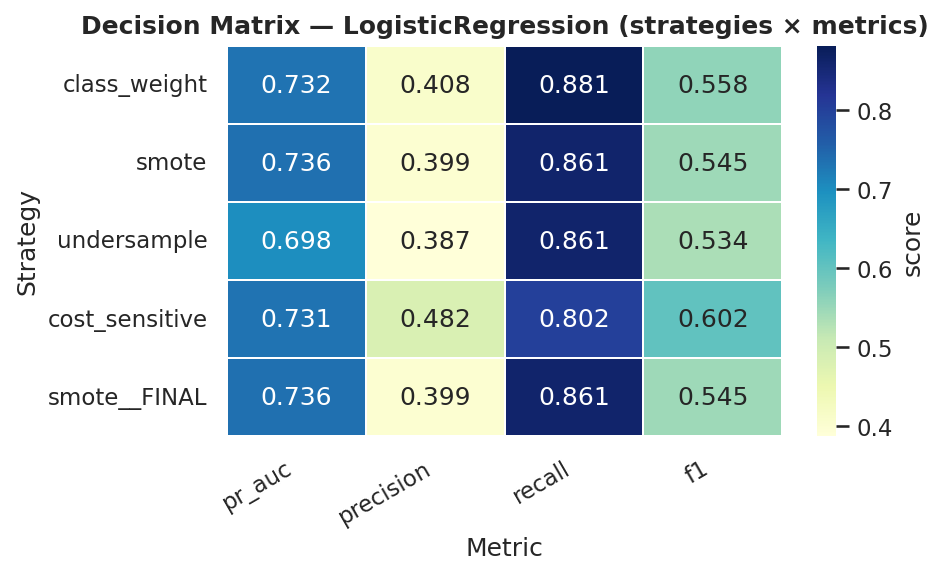

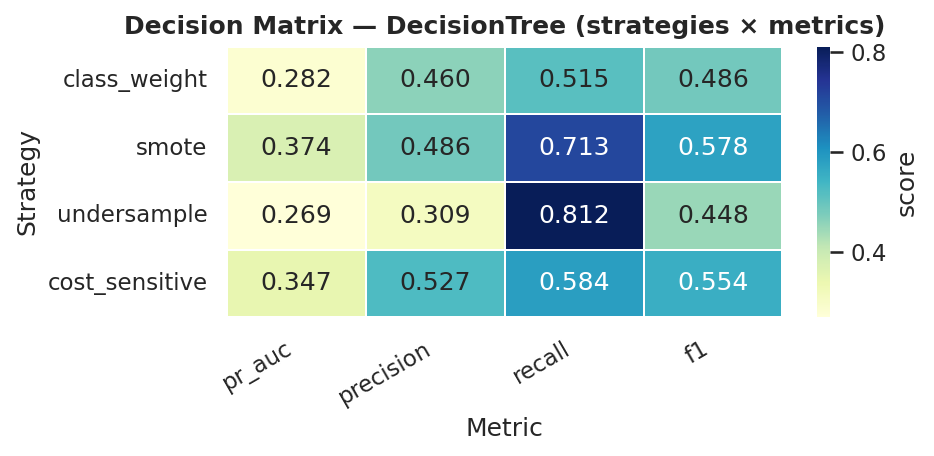

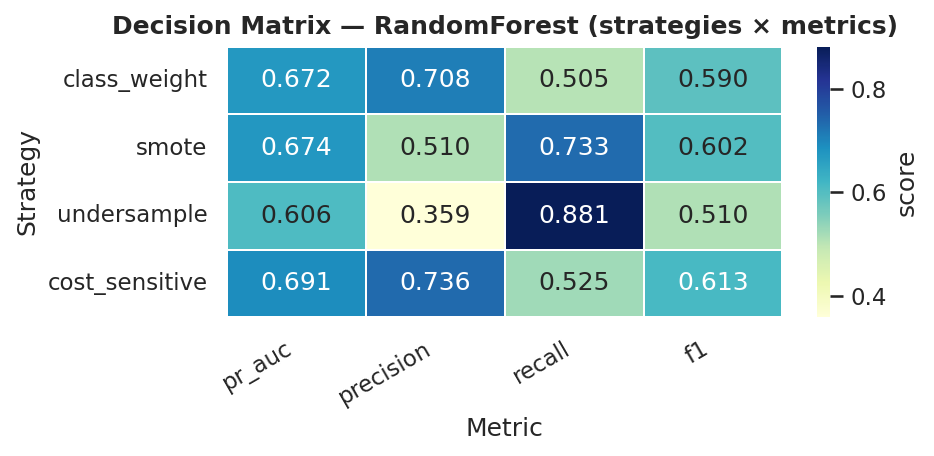

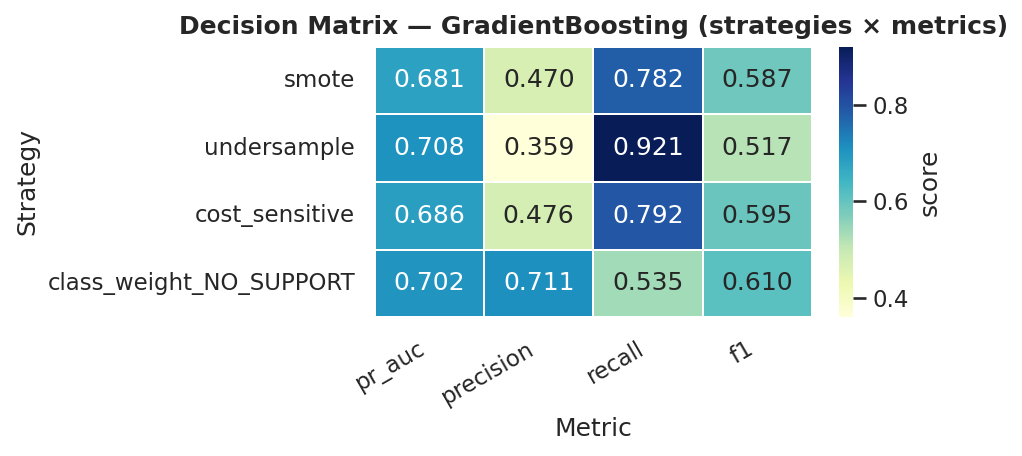

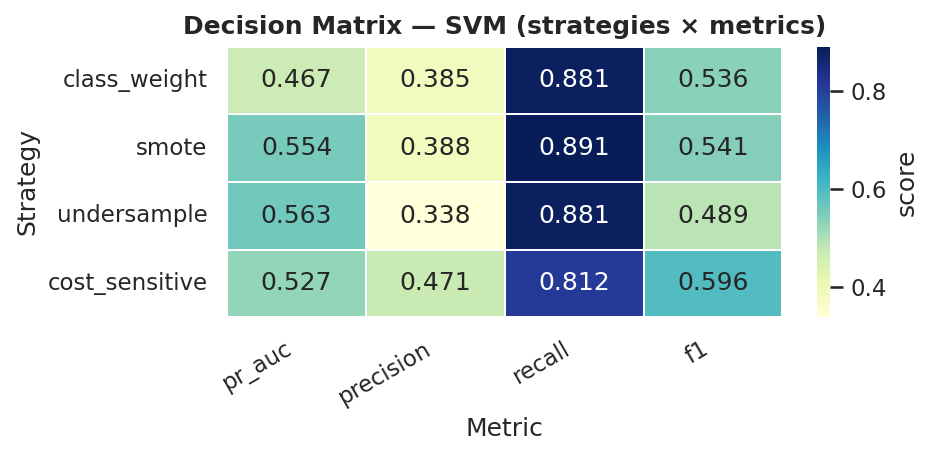

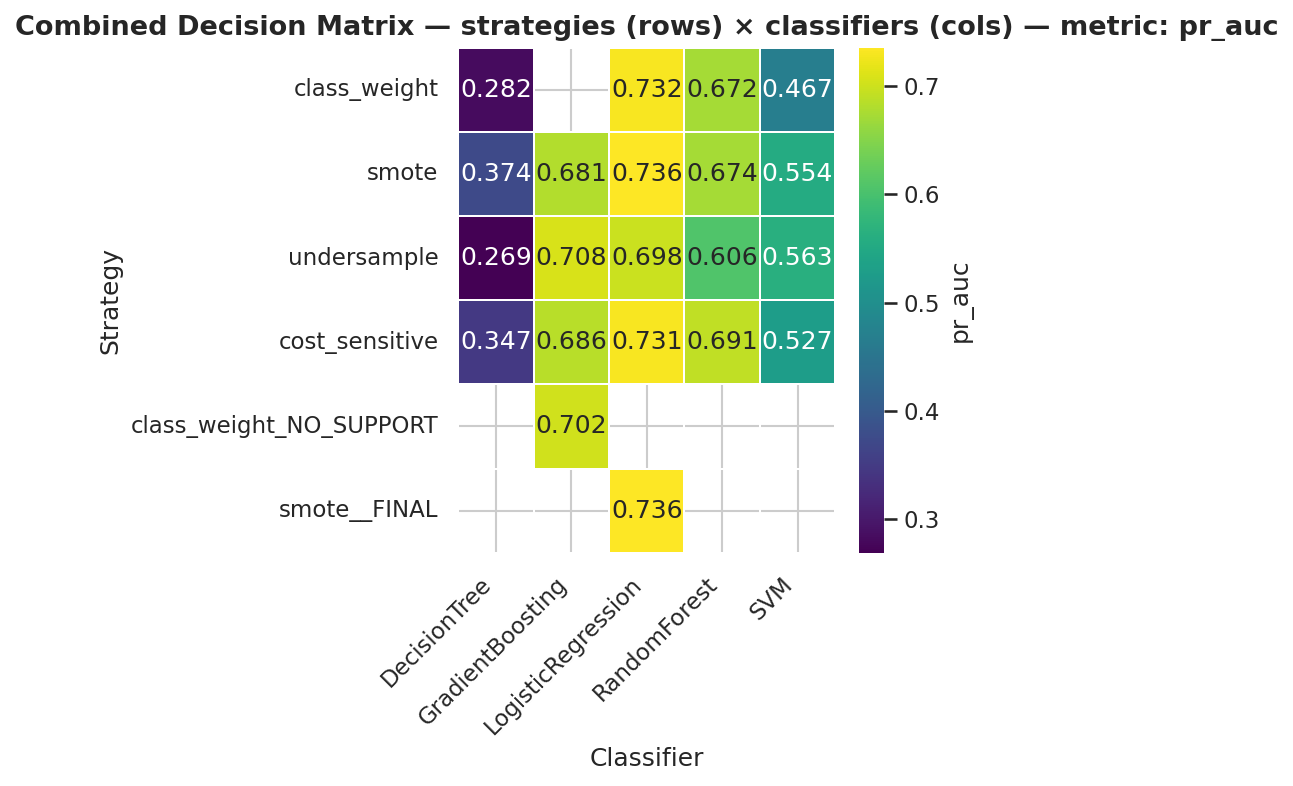

Decision-matrix heatmaps + combined matrix saved to: visualizations_decision_matrices


In [9]:
# Visualization: Decision-matrix heatmaps per classifier (visually appealing)
# - Reads "model_comparison_results_train_val_test_full.csv" (must exist)
# - Produces one decision-matrix heatmap per classifier (strategies × metrics)
# - Produces a combined heatmap (strategies × classifiers) for a chosen metric (PR-AUC)
# - Saves PNGs and shows plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 150})

# ---------- config ----------
SUMMARY_CSV = "/content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv"  # produced earlier
OUT_DIR = "visualizations_decision_matrices"
os.makedirs(OUT_DIR, exist_ok=True)

# metrics to show in each decision matrix (columns)
METRICS = ["pr_auc", "precision", "recall", "f1"]  # order shown
ANNOT_FMT = "{:.3f}"

# color maps
HEATMAP_CMAP = "YlGnBu"       # pleasant perceptual colormap
COMBINED_CMAP = "viridis"

# ---------- load summary ----------
df = pd.read_csv(SUMMARY_CSV)

# prefer using test rows (final performance)
test_df = df[df["dataset"] == "test"].copy()
if test_df.empty:
    # fallback to validation rows if test rows are missing
    test_df = df[df["dataset"] == "val"].copy()

# Normalize metric names present
available_metrics = [m for m in METRICS if m in test_df.columns]
if not available_metrics:
    raise RuntimeError("None of the requested METRICS found in summary CSV columns.")

# ---------- parse model/strategy names ----------
# model column expected format: "Classifier__strategy" (some may have suffixes)
def split_model_name(full):
    parts = str(full).split("__")
    model = parts[0]
    strategy = "__".join(parts[1:]) if len(parts) > 1 else "base"
    return model, strategy

test_df[["classifier", "strategy"]] = test_df["model"].apply(lambda x: pd.Series(split_model_name(x)))

# Ensure strategy ordering (nice consistent order)
strategy_order = [
    "class_weight", "smote", "undersample", "cost_sensitive",
    "class_weight_NO_SUPPORT", "cost_sensitive_sample_weight", "cost_sensitive_NO_SUPPORT"
]
# Add any unseen strategies preserving original order
unique_strats = list(dict.fromkeys(test_df["strategy"].tolist()))
for s in unique_strats:
    if s not in strategy_order:
        strategy_order.append(s)

# ---------- per-classifier decision matrices ----------
classifiers = test_df["classifier"].unique()
for clf in classifiers:
    sub = test_df[test_df["classifier"] == clf].copy()
    if sub.empty:
        continue

    # pivot: strategies x metrics
    # for missing metrics, fill with NaN
    heat_df = pd.DataFrame(index=sorted(sub["strategy"].unique(), key=lambda x: strategy_order.index(x) if x in strategy_order else 999),
                           columns=available_metrics, dtype=float)

    for _, row in sub.iterrows():
        strat = row["strategy"]
        for m in available_metrics:
            val = row.get(m, np.nan)
            heat_df.loc[strat, m] = np.nan if pd.isna(val) else float(val)

    # reorder strategies to preferred order (keep those present)
    present_strats = [s for s in strategy_order if s in heat_df.index] + [s for s in heat_df.index if s not in strategy_order]
    heat_df = heat_df.reindex(present_strats)

    # create figure
    fig, ax = plt.subplots(figsize=(max(6, 1.6 * len(available_metrics)), max(3, 0.8 * len(heat_df.index))))
    # determine vmin/vmax for color scaling per matrix to highlight differences
    vmin = np.nanmin(heat_df.values)
    vmax = np.nanmax(heat_df.values)
    # if all NaN or vmin==vmax, set defaults
    if np.isnan(vmin) or np.isnan(vmax) or vmin == vmax:
        vmin, vmax = 0.0, 1.0

    sns.heatmap(heat_df.astype(float), annot=True, fmt=".3f", linewidths=0.8, linecolor="white",
                cmap=HEATMAP_CMAP, vmin=vmin, vmax=vmax, cbar_kws={"label": "score"}, ax=ax)

    ax.set_title(f"Decision Matrix — {clf} (strategies × metrics)", fontsize=12, weight="bold")
    ax.set_xlabel("Metric")
    ax.set_ylabel("Strategy")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, f"decision_matrix_{clf}.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# ---------- combined heatmap: strategies x classifiers for a chosen metric ----------
# choose metric for combined view (PR-AUC recommended)
COMBINED_METRIC = "pr_auc"
if COMBINED_METRIC not in test_df.columns:
    COMBINED_METRIC = available_metrics[0]  # fallback

pivot = test_df.pivot_table(index="strategy", columns="classifier", values=COMBINED_METRIC, aggfunc="mean")

# reorder rows/cols for clarity
# strategies: strategy_order intersection
row_order = [s for s in strategy_order if s in pivot.index] + [s for s in pivot.index if s not in strategy_order]
col_order = sorted(pivot.columns.tolist())  # alphabetical classifiers
pivot = pivot.reindex(index=row_order, columns=col_order)

# plotting combined heatmap
fig, ax = plt.subplots(figsize=(max(6, 1.2 * len(col_order)), max(4, 0.9 * len(pivot.index))))
vmin = np.nanmin(pivot.values) if not np.isnan(pivot.values).all() else 0.0
vmax = np.nanmax(pivot.values) if not np.isnan(pivot.values).all() else 1.0
if vmin == vmax:
    vmin, vmax = 0.0, 1.0

sns.heatmap(pivot.astype(float), annot=True, fmt=".3f", cmap=COMBINED_CMAP, linewidths=0.8, linecolor="white",
            vmin=vmin, vmax=vmax, cbar_kws={"label": COMBINED_METRIC}, ax=ax)

ax.set_title(f"Combined Decision Matrix — strategies (rows) × classifiers (cols) — metric: {COMBINED_METRIC}", fontsize=13, weight="bold")
ax.set_xlabel("Classifier"); ax.set_ylabel("Strategy")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
out_path = os.path.join(OUT_DIR, f"combined_decision_matrix_{COMBINED_METRIC}.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()
plt.close(fig)

# ---------- optional: rank table and save ----------
rank_table = test_df.copy()
# compute a simple composite score (weighted): 0.5*pr_auc + 0.25*precision + 0.25*recall (only if cols exist)
weights = {"pr_auc": 0.5, "precision": 0.25, "recall": 0.25}
available_for_score = [c for c in ["pr_auc","precision","recall"] if c in rank_table.columns]
if available_for_score:
    rank_table["composite_score"] = 0.0
    total_w = sum(weights[k] for k in available_for_score if k in weights)
    for k in available_for_score:
        rank_table["composite_score"] += rank_table[k].fillna(0.0) * (weights[k] / total_w)
    rank_table = rank_table.sort_values(by="composite_score", ascending=False)
    rank_table.to_csv(os.path.join(OUT_DIR, "decision_matrix_rank_table.csv"), index=False)

print("Decision-matrix heatmaps + combined matrix saved to:", OUT_DIR)


Loaded GB+SMOTE: TPR=0.7426, FPR=0.0754
Loaded LR+SMOTE: TPR=0.8515, FPR=0.1305
Loaded RF+SMOTE: TPR=0.7030, FPR=0.0550
Loaded RF+Weight: TPR=0.5446, FPR=0.0204


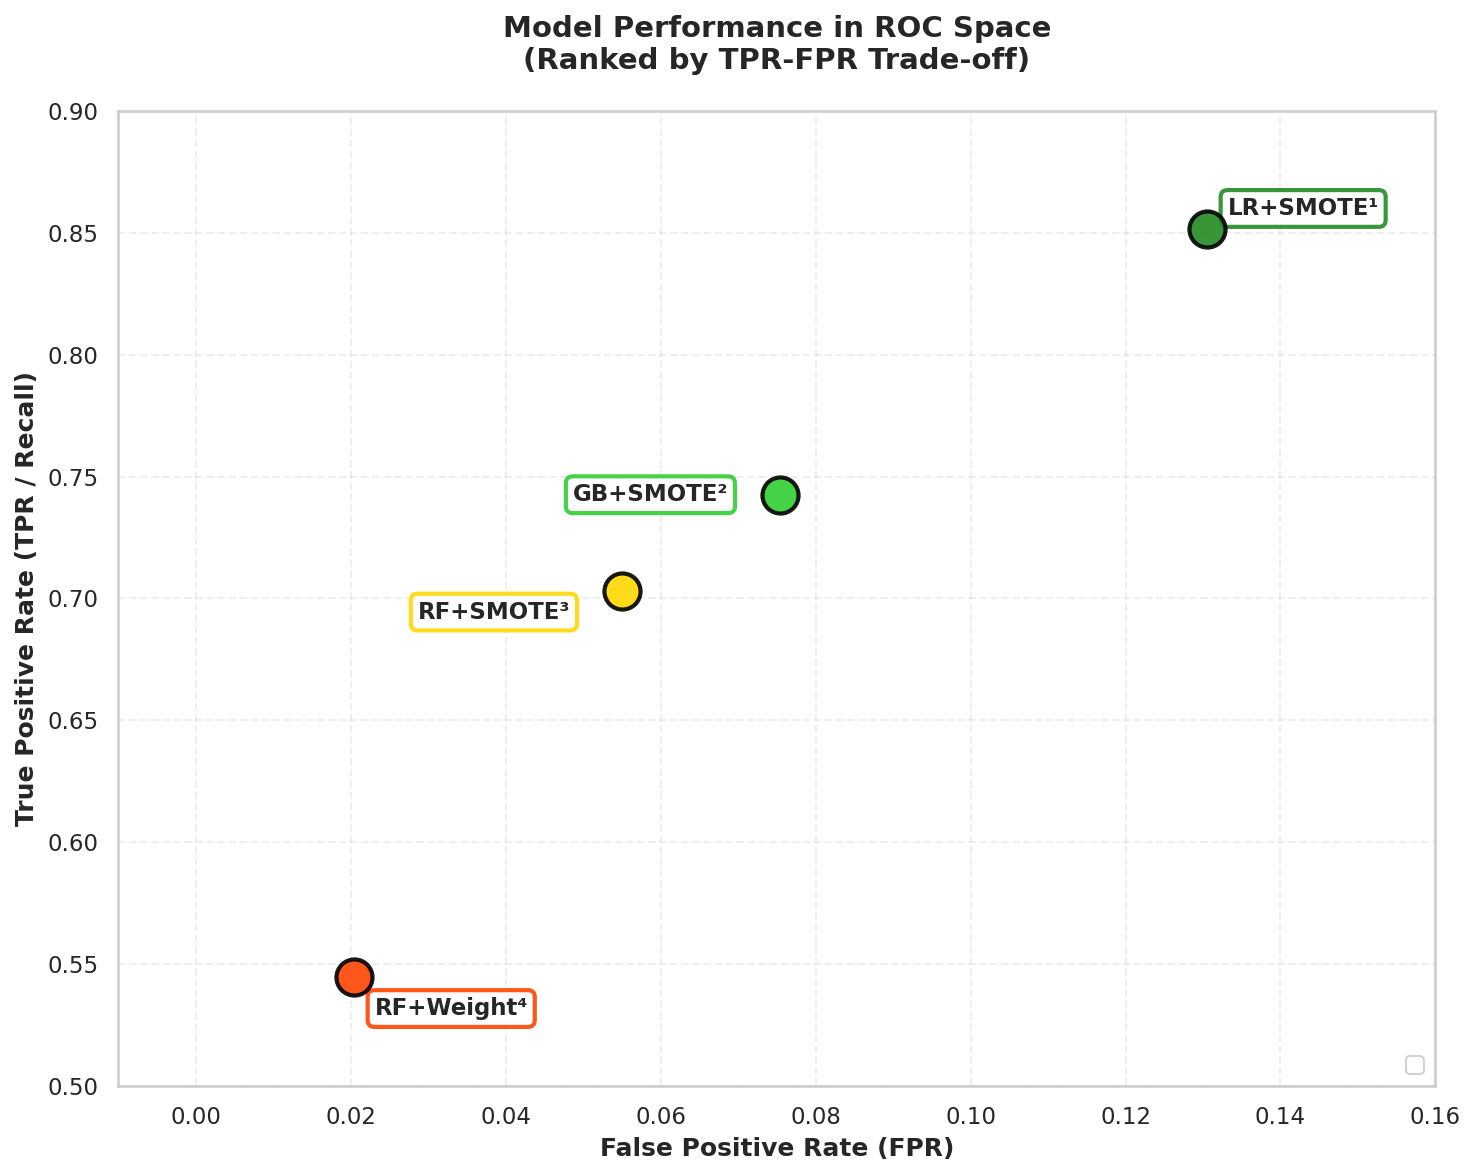


MODEL RANKING BY TPR-FPR TRADE-OFF (4 Models)

Rank | Model           | TPR    | FPR    | Distance from Ideal (0,1)
-----------------------------------------------------------------
   1 | LR+SMOTE        | 0.8515 | 0.1305 | 0.1977
   2 | GB+SMOTE        | 0.7426 | 0.0754 | 0.2683
   3 | RF+SMOTE        | 0.7030 | 0.0550 | 0.3021
   4 | RF+Weight       | 0.5446 | 0.0204 | 0.4559
-----------------------------------------------------------------

Interpretation:
• Lower distance from ideal point (0,1) = better trade-off
• Ideal: High TPR (catch positives) + Low FPR (few false alarms)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your CSV file
df = pd.read_csv('/content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv')

# Extract the relevant rows based on your model names - REMOVED GB+Cost
model_filters = {
    'GB+SMOTE': 'GradientBoosting__smote',
    'LR+SMOTE': 'LogisticRegression__smote',
    'RF+SMOTE': 'RandomForest__smote',
    # 'GB+Cost': 'GradientBoosting__cost_sensitive_sample_weight',  # REMOVED
    'RF+Weight': 'RandomForest__class_weight'
}

# Initialize lists to store data
models = []
tp = []
fp = []
tn = []
fn = []
tpr = []
fpr = []

# Extract data for each model
for display_name, model_pattern in model_filters.items():
    # Find the row for this model (assuming dataset='val')
    model_data = df[(df['model'].str.contains(model_pattern)) & (df['dataset'] == 'val')]

    if not model_data.empty:
        models.append(display_name)
        tp.append(int(model_data['tp'].iloc[0]))
        fp.append(int(model_data['fp'].iloc[0]))
        tn.append(int(model_data['tn'].iloc[0]))
        fn.append(int(model_data['fn'].iloc[0]))

        # Calculate TPR and FPR
        tpr_val = tp[-1] / (tp[-1] + fn[-1])
        fpr_val = fp[-1] / (fp[-1] + tn[-1])

        tpr.append(tpr_val)
        fpr.append(fpr_val)

        print(f"Loaded {display_name}: TPR={tpr_val:.4f}, FPR={fpr_val:.4f}")
    else:
        print(f"Warning: Could not find data for {display_name} ({model_pattern})")

# Convert to numpy arrays for calculations
tpr = np.array(tpr)
fpr = np.array(fpr)

# Calculate trade-off score: balance between TPR and low FPR
# We'll use distance from ideal point (0,1) - smaller distance = better trade-off
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Rank models by trade-off (closest to ideal point = best)
ranked_indices = np.argsort(distances)  # Sort from smallest to largest distance

# Assign colors based on ranking - updated for 4 models
colors = []
for i in range(len(models)):
    if i == ranked_indices[0]:   # Best trade-off (1st place)
        colors.append('#228B22')  # Forest Green
    elif i == ranked_indices[1]: # Second best (2nd place)
        colors.append('#32CD32')  # Lime Green
    elif i == ranked_indices[2]: # Third best (3rd place)
        colors.append('#FFD700')  # Gold/Yellow
    else:                        # Fourth best (4th place)
        colors.append('#FF4500')  # Orange Red

plt.figure(figsize=(10, 8))

# Create scatter plot with ranked colors
for i, (x, y) in enumerate(zip(fpr, tpr)):
    plt.scatter(x, y, s=300, color=colors[i],
                edgecolors='black', linewidth=2, alpha=0.9, zorder=5)

# Define custom label positions to avoid overlap - updated for 4 models
label_offsets = [
    (-25, 0),    # GB+SMOTE: LEFT of point
    (10, 10),    # LR+SMOTE: RIGHT and UP
    (-25, -10),  # RF+SMOTE: LEFT and DOWN
    (10, -15),   # RF+Weight: RIGHT and DOWN
]

# Add model labels with custom positioning
for i, model in enumerate(models):
    # Add ranking number to label
    rank = np.where(ranked_indices == i)[0][0] + 1  # Convert to 1-based ranking
    rank_symbol = ['¹', '²', '³', '⁴'][rank-1]  # Updated for 4 models

    offset_x, offset_y = label_offsets[i]

    # Determine text alignment based on offset direction
    ha = 'right' if offset_x < 0 else 'left'

    plt.annotate(f"{model}{rank_symbol}",
                 (fpr[i], tpr[i]),
                 xytext=(offset_x, offset_y),
                 textcoords='offset points',
                 fontsize=11,
                 fontweight='bold',
                 ha=ha,
                 va='center',
                 bbox=dict(boxstyle='round,pad=0.3',
                          facecolor='white',
                          alpha=0.9,
                          edgecolor=colors[i],
                          linewidth=2))

# Customize plot
plt.xlim([-0.01, 0.16])
plt.ylim([0.5, 0.9])
plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (TPR / Recall)', fontsize=12, fontweight='bold')
plt.title('Model Performance in ROC Space\n(Ranked by TPR-FPR Trade-off)',
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')

# Add legend
plt.legend(loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.show()

# Print ranking details
print("\n" + "=" * 60)
print("MODEL RANKING BY TPR-FPR TRADE-OFF (4 Models)")
print("=" * 60)
print("\nRank | Model           | TPR    | FPR    | Distance from Ideal (0,1)")
print("-" * 65)

for rank, idx in enumerate(ranked_indices, 1):
    print(f"{rank:4d} | {models[idx]:<15} | {tpr[idx]:.4f} | {fpr[idx]:.4f} | {distances[idx]:.4f}")

print("-" * 65)
print("\nInterpretation:")
print("• Lower distance from ideal point (0,1) = better trade-off")
print("• Ideal: High TPR (catch positives) + Low FPR (few false alarms)")
print("=" * 60)

Loaded TEST data for GradientBoost+SMOTE
Loaded TEST data for LogisticReg+SMOTE
Loaded TEST data for RandomForest+SMOTE
Loaded TEST data for RandomForest+Weight


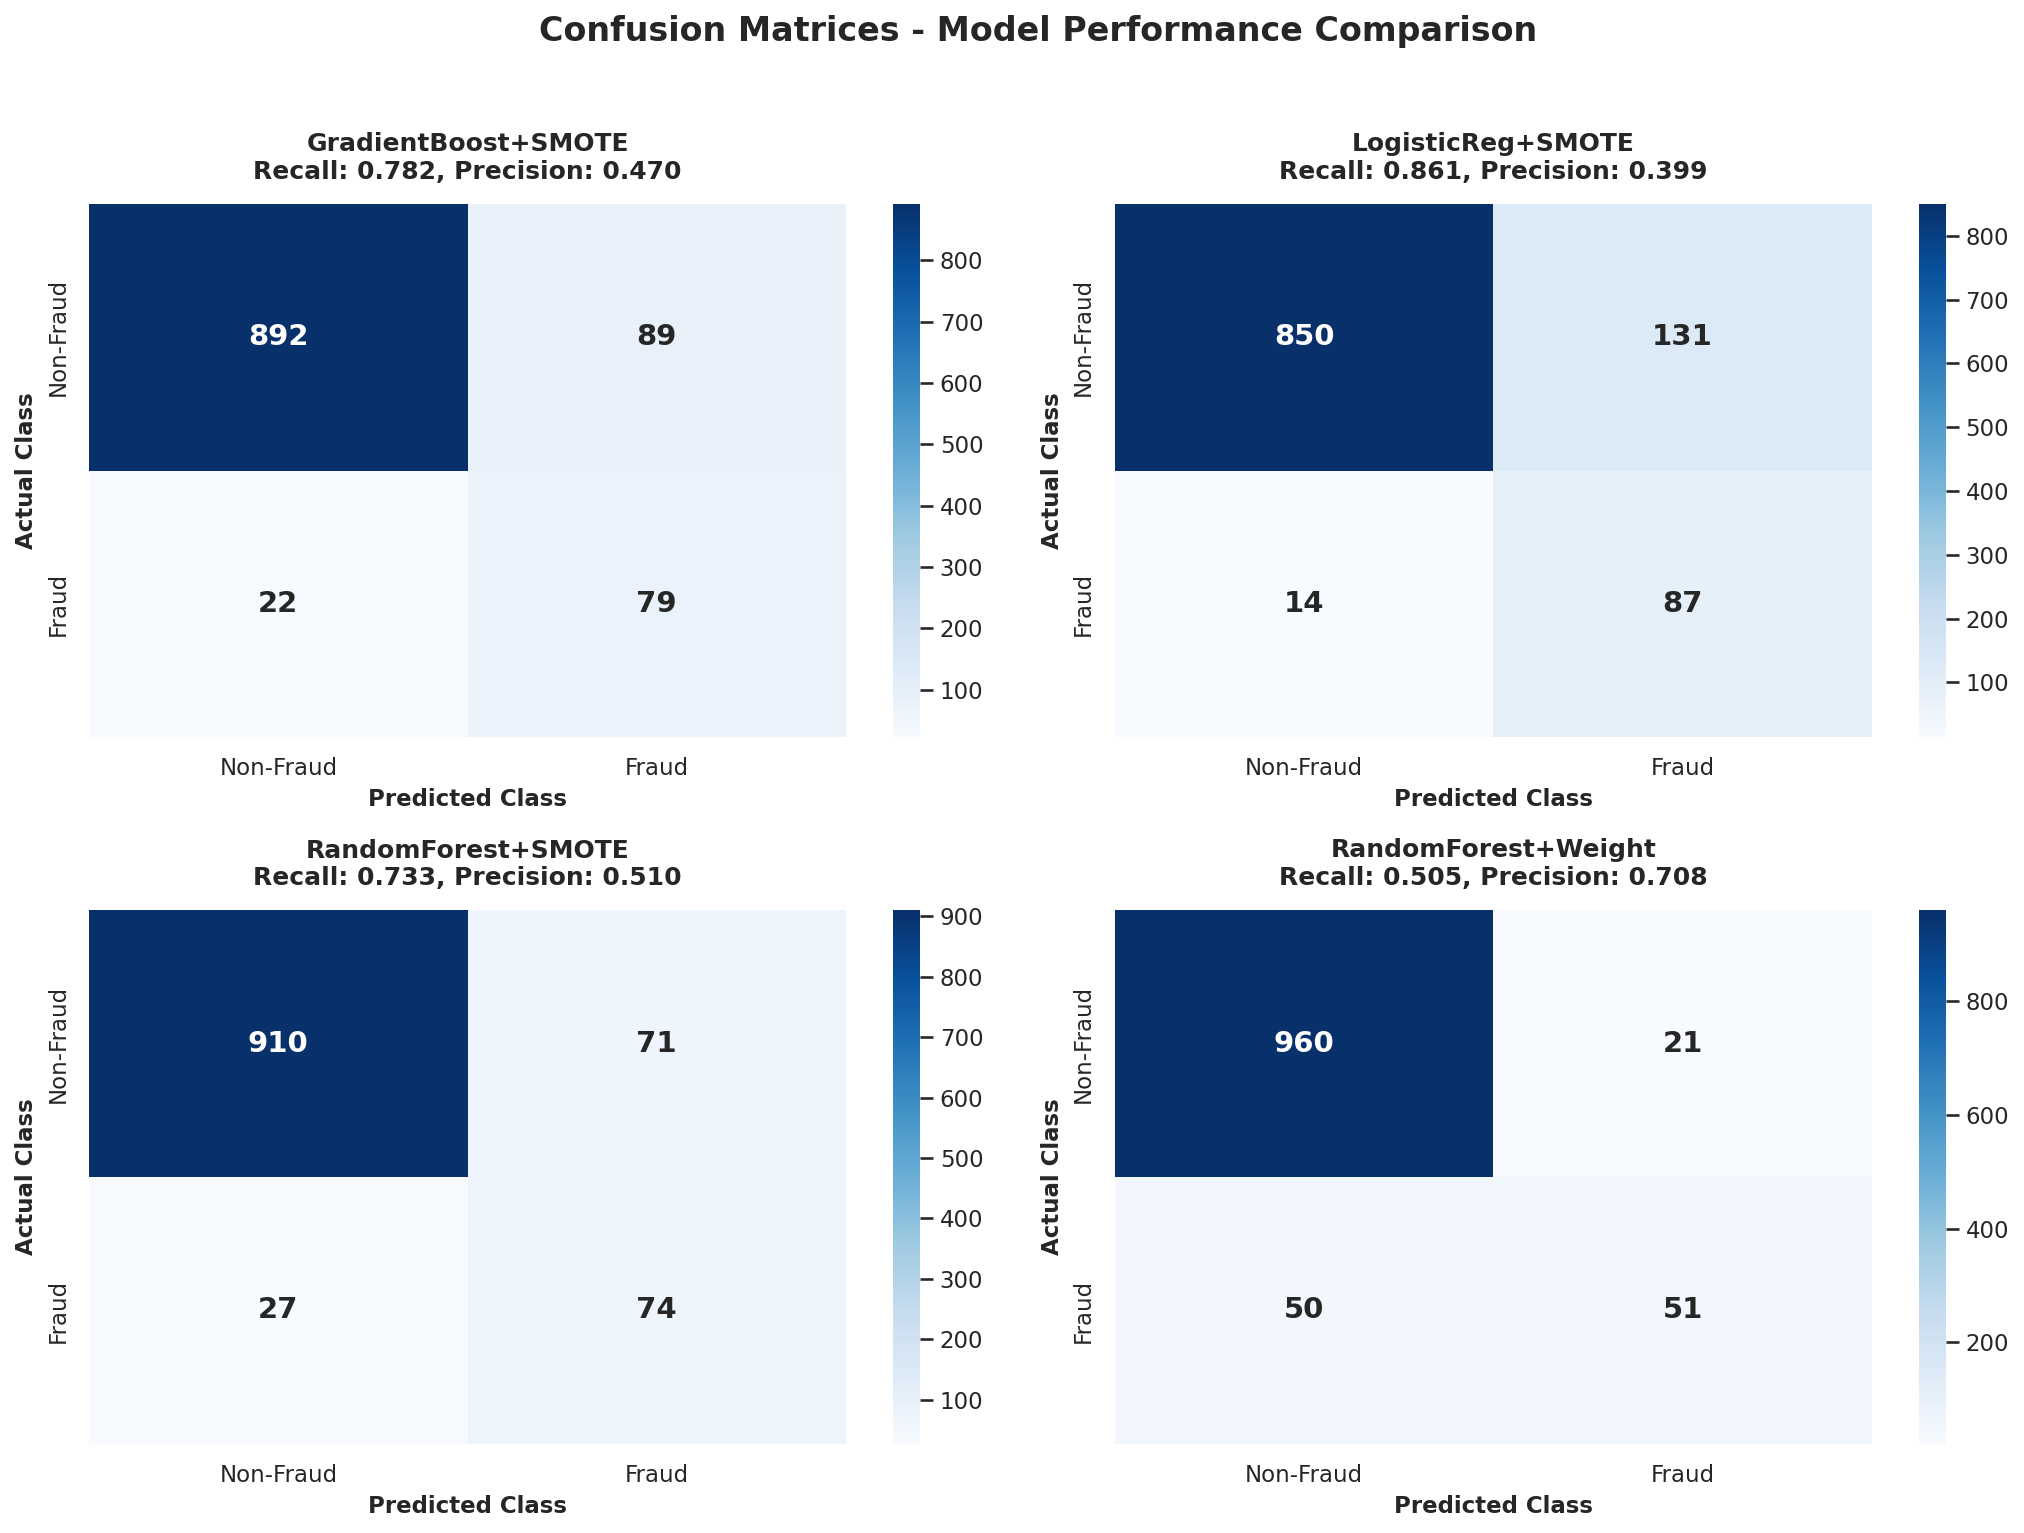

✅ Confusion matrices saved as 'confusion_matrices.png'

CONFUSION MATRIX DATA SUMMARY
Model                     TP     FP     TN     FN     Recall   Precision 
----------------------------------------------------------------------
GradientBoost+SMOTE       79     89     892    22     0.7822   0.4702    
LogisticReg+SMOTE         87     131    850    14     0.8614   0.3991    
RandomForest+SMOTE        74     71     910    27     0.7327   0.5103    
RandomForest+Weight       51     21     960    50     0.5050   0.7083    

Interpretation:
• TP: Correctly identified Fraud cases
• FP: False alarms (Non-Fraud incorrectly flagged as Fraud)
• TN: Correctly identified Non-Fraud cases
• FN: Missed Fraud cases (Fraud cases incorrectly classified as Non-Fraud)
• Recall: TP/(TP+FN) - Ability to detect Fraud cases
• Precision: TP/(TP+FP) - Accuracy of Fraud predictions


In [13]:
# ========================================
# CONFUSION MATRICES VISUALIZATION ONLY
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load your CSV file
df = pd.read_csv('/content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv')

# Define model filters - REMOVED GB+Cost
model_filters = {
    'GradientBoost+SMOTE': 'GradientBoosting__smote',
    'LogisticReg+SMOTE': 'LogisticRegression__smote',
    'RandomForest+SMOTE': 'RandomForest__smote',
    'RandomForest+Weight': 'RandomForest__class_weight'
}

# Initialize data storage
models = []
pr_auc = []
recall = []
precision = []
f1_scores = []
tp = []
fp = []
tn = []
fn = []

# Extract data for each model from TEST dataset
for display_name, model_pattern in model_filters.items():
    # Find the row for this model (using dataset='test')
    model_data = df[(df['model'].str.contains(model_pattern)) & (df['dataset'] == 'test')]

    if not model_data.empty:
        row = model_data.iloc[0]
        models.append(display_name)

        # Extract metrics (adjust column names if needed)
        pr_auc.append(float(row['pr_auc']))

        # Check column names - sometimes they might have different capitalization
        recall_col = 'recall' if 'recall' in row else 'Recall'
        precision_col = 'precision' if 'precision' in row else 'Precision'
        f1_col = 'f1' if 'f1' in row else 'F1' if 'F1' in row else 'f1_score'

        recall.append(float(row[recall_col]))
        precision.append(float(row[precision_col]))
        f1_scores.append(float(row[f1_col]))

        tp.append(int(row['tp']))
        fp.append(int(row['fp']))
        tn.append(int(row['tn']))
        fn.append(int(row['fn']))

        print(f"Loaded TEST data for {display_name}")
    else:
        print(f"Warning: Could not find TEST data for {display_name}")
        # Try to load validation data as fallback
        model_data_val = df[(df['model'].str.contains(model_pattern)) & (df['dataset'] == 'val')]
        if not model_data_val.empty:
            row = model_data_val.iloc[0]
            models.append(display_name)

            pr_auc.append(float(row['pr_auc']))
            recall_col = 'recall' if 'recall' in row else 'Recall'
            precision_col = 'precision' if 'precision' in row else 'Precision'
            f1_col = 'f1' if 'f1' in row else 'F1' if 'F1' in row else 'f1_score'

            recall.append(float(row[recall_col]))
            precision.append(float(row[precision_col]))
            f1_scores.append(float(row[f1_col]))

            tp.append(int(row['tp']))
            fp.append(int(row['fp']))
            tn.append(int(row['tn']))
            fn.append(int(row['fn']))

            print(f"  Used VAL data as fallback for {display_name}")

# Create DataFrame from extracted data
results_df = pd.DataFrame({
    'Model': models,
    'PR-AUC': pr_auc,
    'Recall': recall,
    'Precision': precision,
    'F1-Score': f1_scores,
    'TP': tp,
    'FP': fp,
    'TN': tn,
    'FN': fn
})

# CONFUSION MATRICES FOR 4 MODELS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (idx, row) in enumerate(results_df.iterrows()):
    ax = axes[i]

    # Confusion matrix format: [[TN, FP], [FN, TP]]
    cm = np.array([[row['TN'], row['FP']],
                   [row['FN'], row['TP']]])

    # Create heatmap with fraud/non-fraud labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=True, ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                annot_kws={"size": 14, "weight": "bold"})

    # Add title with performance metrics
    title_text = f"{row['Model']}\nRecall: {row['Recall']:.3f}, Precision: {row['Precision']:.3f}"
    ax.set_title(title_text, fontweight='bold', fontsize=12, pad=12)
    ax.set_xlabel('Predicted Class', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual Class', fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices - Model Performance Comparison',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved as 'confusion_matrices.png'")

# Print summary for verification
print("\n" + "="*70)
print("CONFUSION MATRIX DATA SUMMARY")
print("="*70)
print(f"{'Model':<25} {'TP':<6} {'FP':<6} {'TN':<6} {'FN':<6} {'Recall':<8} {'Precision':<10}")
print("-"*70)
for i, row in results_df.iterrows():
    print(f"{row['Model']:<25} {row['TP']:<6} {row['FP']:<6} {row['TN']:<6} {row['FN']:<6} {row['Recall']:<8.4f} {row['Precision']:<10.4f}")
print("="*70)

print("\nInterpretation:")
print("• TP: Correctly identified Fraud cases")
print("• FP: False alarms (Non-Fraud incorrectly flagged as Fraud)")
print("• TN: Correctly identified Non-Fraud cases")
print("• FN: Missed Fraud cases (Fraud cases incorrectly classified as Non-Fraud)")
print("• Recall: TP/(TP+FN) - Ability to detect Fraud cases")
print("• Precision: TP/(TP+FP) - Accuracy of Fraud predictions")

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Load your CSV file
df = pd.read_csv('/content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv')

# Define model filters - REMOVED GB+Cost
model_filters = {
    'GB+SMOTE': 'GradientBoosting__smote',
    'LR+SMOTE': 'LogisticRegression__smote',
    'RF+SMOTE': 'RandomForest__smote',
    # 'GB+Cost': 'GradientBoosting__cost_sensitive_sample_weight',  # REMOVED
    'RF+Weight': 'RandomForest__class_weight'
}

# Initialize data storage
models = []
pr_auc = []
recall = []
precision = []
f1_scores = []
tp = []
fp = []
fn = []
tn = []

# Extract data for each model from TEST dataset
for display_name, model_pattern in model_filters.items():
    # Find the row for this model (using dataset='test')
    model_data = df[(df['model'].str.contains(model_pattern)) & (df['dataset'] == 'test')]

    if not model_data.empty:
        row = model_data.iloc[0]
        models.append(display_name)

        # Extract metrics (adjust column names if needed)
        pr_auc.append(float(row['pr_auc']))

        # Check column names - sometimes they might have different capitalization
        recall_col = 'recall' if 'recall' in row else 'Recall'
        precision_col = 'precision' if 'precision' in row else 'Precision'
        f1_col = 'f1' if 'f1' in row else 'F1' if 'F1' in row else 'f1_score'

        recall.append(float(row[recall_col]))
        precision.append(float(row[precision_col]))
        f1_scores.append(float(row[f1_col]))

        tp.append(int(row['tp']))
        fp.append(int(row['fp']))
        fn.append(int(row['fn']))

        print(f"Loaded TEST data for {display_name}")
    else:
        print(f"Warning: Could not find TEST data for {display_name}")
        # Try to load validation data as fallback
        model_data_val = df[(df['model'].str.contains(model_pattern)) & (df['dataset'] == 'val')]
        if not model_data_val.empty:
            row = model_data_val.iloc[0]
            models.append(display_name)

            pr_auc.append(float(row['pr_auc']))
            recall_col = 'recall' if 'recall' in row else 'Recall'
            precision_col = 'precision' if 'precision' in row else 'Precision'
            f1_col = 'f1' if 'f1' in row else 'F1' if 'F1' in row else 'f1_score'

            recall.append(float(row[recall_col]))
            precision.append(float(row[precision_col]))
            f1_scores.append(float(row[f1_col]))

            tp.append(int(row['tp']))
            fp.append(int(row['fp']))
            fn.append(int(row['fn']))

            print(f"  Used VAL data as fallback for {display_name}")

# Create interactive dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('PR-AUC Comparison (Test)', 'Recall vs Precision (Test)',
                    'Confusion Matrix Heat (Test)', 'Performance Metrics (Test)'),
    specs=[[{'type': 'bar'}, {'type': 'scatter'}],
           [{'type': 'heatmap'}, {'type': 'bar'}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# Updated colors for 4 models (removed the red color that was for GB+Cost)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']  # Blue, Orange, Green, Purple

# 1. Bar chart - PR-AUC
fig.add_trace(
    go.Bar(x=models, y=pr_auc,
           marker_color=colors,
           text=[f'{x:.3f}' for x in pr_auc],
           textposition='auto',
           name='PR-AUC',
           hovertemplate='<b>%{x}</b><br>PR-AUC: %{y:.3f}<extra></extra>'),
    row=1, col=1
)

# 2. Scatter plot - Recall vs Precision
fig.add_trace(
    go.Scatter(x=recall, y=precision, mode='markers+text',
               marker=dict(size=[s*15 for s in f1_scores],
                          color=colors,  # Changed from pr_auc to colors
                          line=dict(width=2, color='black')),
               text=models,
               textposition="top center",
               name='Models',
               hovertemplate='<b>%{text}</b><br>Recall: %{x:.3f}<br>Precision: %{y:.3f}<extra></extra>'),
    row=1, col=2
)

# 3. Heatmap - Confusion Matrix Summary
# Calculate additional metrics for heatmap
confusion_values = []
for i in range(len(models)):
    total = tp[i] + fp[i] + fn[i]
    ratio = tp[i] / total if total > 0 else 0
    confusion_values.append([tp[i], fp[i], fn[i], ratio])

fig.add_trace(
    go.Heatmap(z=confusion_values,
               x=['TP', 'FP', 'FN', 'TP/(TP+FP+FN)'],
               y=models,
               colorscale='RdBu',
               text=[[f"{val:.0f}" if j < 3 else f"{val:.2%}" for j, val in enumerate(row)]
                     for row in confusion_values],
               texttemplate="%{text}",
               textfont={"size": 10},
               name='Confusion Matrix',
               hovertemplate='<b>%{y}</b><br>%{x}: %{text}<extra></extra>'),
    row=2, col=1
)

# 4. Grouped bar - Scores with shades of blue
fig.add_trace(
    go.Bar(name='Recall', x=models, y=recall,
           marker_color='#87CEEB',  # Sky Blue (light)
           hovertemplate='<b>%{x}</b><br>Recall: %{y:.3f}<extra></extra>'),
    row=2, col=2
)
fig.add_trace(
    go.Bar(name='Precision', x=models, y=precision,
           marker_color='#4682B4',  # Steel Blue (medium)
           hovertemplate='<b>%{x}</b><br>Precision: %{y:.3f}<extra></extra>'),
    row=2, col=2
)
fig.add_trace(
    go.Bar(name='F1-Score', x=models, y=f1_scores,
           marker_color='#191970',  # Midnight Blue (dark)
           hovertemplate='<b>%{x}</b><br>F1-Score: %{y:.3f}<extra></extra>'),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="Model Performance Dashboard - TEST Evaluation (4 Models)",
    title_font_size=20,
    showlegend=True,
    height=800,
    bargap=0.15,
    bargroupgap=0.1,
    hovermode='closest',
    template='plotly_white'
)

# Update axes labels
fig.update_xaxes(title_text="Models", row=1, col=1)
fig.update_yaxes(title_text="PR-AUC Score", row=1, col=1)
fig.update_xaxes(title_text="Recall", row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)
fig.update_xaxes(title_text="Confusion Matrix Metrics", row=2, col=1)
fig.update_yaxes(title_text="Models", row=2, col=1)
fig.update_xaxes(title_text="Models", row=2, col=2)
fig.update_yaxes(title_text="Score Value", row=2, col=2)

# Add some formatting
fig.update_yaxes(range=[min(pr_auc)*0.9, max(pr_auc)*1.1], row=1, col=1)
fig.update_yaxes(range=[min(recall+precision+f1_scores)*0.8,
                        max(recall+precision+f1_scores)*1.1], row=1, col=2)
fig.update_yaxes(range=[0, max(recall+precision+f1_scores)*1.1], row=2, col=2)

fig.show()

# Print loaded data for verification
print("\n" + "="*80)
print("TEST EVALUATION DATA SUMMARY (4 Models - GB+Cost Removed)")
print("="*80)
print(f"{'Model':<15} {'PR-AUC':<8} {'Recall':<8} {'Precision':<10} {'F1':<8} {'TP':<5} {'FP':<5} {'FN':<5}")
print("-"*80)
for i in range(len(models)):
    print(f"{models[i]:<15} {pr_auc[i]:<8.4f} {recall[i]:<8.4f} {precision[i]:<10.4f} {f1_scores[i]:<8.4f} {tp[i]:<5} {fp[i]:<5} {fn[i]:<5}")
print("="*80)

# Calculate and print key performance insights
print("\n" + "="*80)
print("PERFORMANCE INSIGHTS (TEST SET - 4 Models)")
print("="*80)

# Best performers
best_pr_auc_idx = np.argmax(pr_auc)
best_recall_idx = np.argmax(recall)
best_precision_idx = np.argmax(precision)
best_f1_idx = np.argmax(f1_scores)

print(f"🏆 Best PR-AUC: {models[best_pr_auc_idx]} ({pr_auc[best_pr_auc_idx]:.4f})")
print(f"🔍 Best Recall: {models[best_recall_idx]} ({recall[best_recall_idx]:.4f})")
print(f"🎯 Best Precision: {models[best_precision_idx]} ({precision[best_precision_idx]:.4f})")
print(f"⚖️  Best F1-Score: {models[best_f1_idx]} ({f1_scores[best_f1_idx]:.4f})")

print("\nTrade-off Analysis:")
print(f"• {models[best_recall_idx]} catches the most positives but may have more false alarms")
print(f"• {models[best_precision_idx]} has the most reliable detections but may miss some positives")
print(f"• {models[best_f1_idx]} offers the best balance between precision and recall")
print("="*80)

Loaded TEST data for GB+SMOTE
Loaded TEST data for LR+SMOTE
Loaded TEST data for RF+SMOTE
Loaded TEST data for RF+Weight



TEST EVALUATION DATA SUMMARY (4 Models - GB+Cost Removed)
Model           PR-AUC   Recall   Precision  F1       TP    FP    FN   
--------------------------------------------------------------------------------
GB+SMOTE        0.6811   0.7822   0.4702     0.5874   79    89    22   
LR+SMOTE        0.7357   0.8614   0.3991     0.5455   87    131   14   
RF+SMOTE        0.6737   0.7327   0.5103     0.6016   74    71    27   
RF+Weight       0.6723   0.5050   0.7083     0.5896   51    21    50   

PERFORMANCE INSIGHTS (TEST SET - 4 Models)
🏆 Best PR-AUC: LR+SMOTE (0.7357)
🔍 Best Recall: LR+SMOTE (0.8614)
🎯 Best Precision: RF+Weight (0.7083)
⚖️  Best F1-Score: RF+SMOTE (0.6016)

Trade-off Analysis:
• LR+SMOTE catches the most positives but may have more false alarms
• RF+Weight has the most reliable detections but may miss some positives
• RF+SMOTE offers the best balance between precision and recall


Loaded GB+SMOTE: TP=75, FP=74, FN=26, TN=907
Loaded LR+SMOTE: TP=86, FP=128, FN=15, TN=853
Loaded RF+SMOTE: TP=71, FP=54, FN=30, TN=927
Loaded GB+Cost: TP=76, FP=74, FN=25, TN=907
Loaded RF+Weight: TP=55, FP=20, FN=46, TN=961


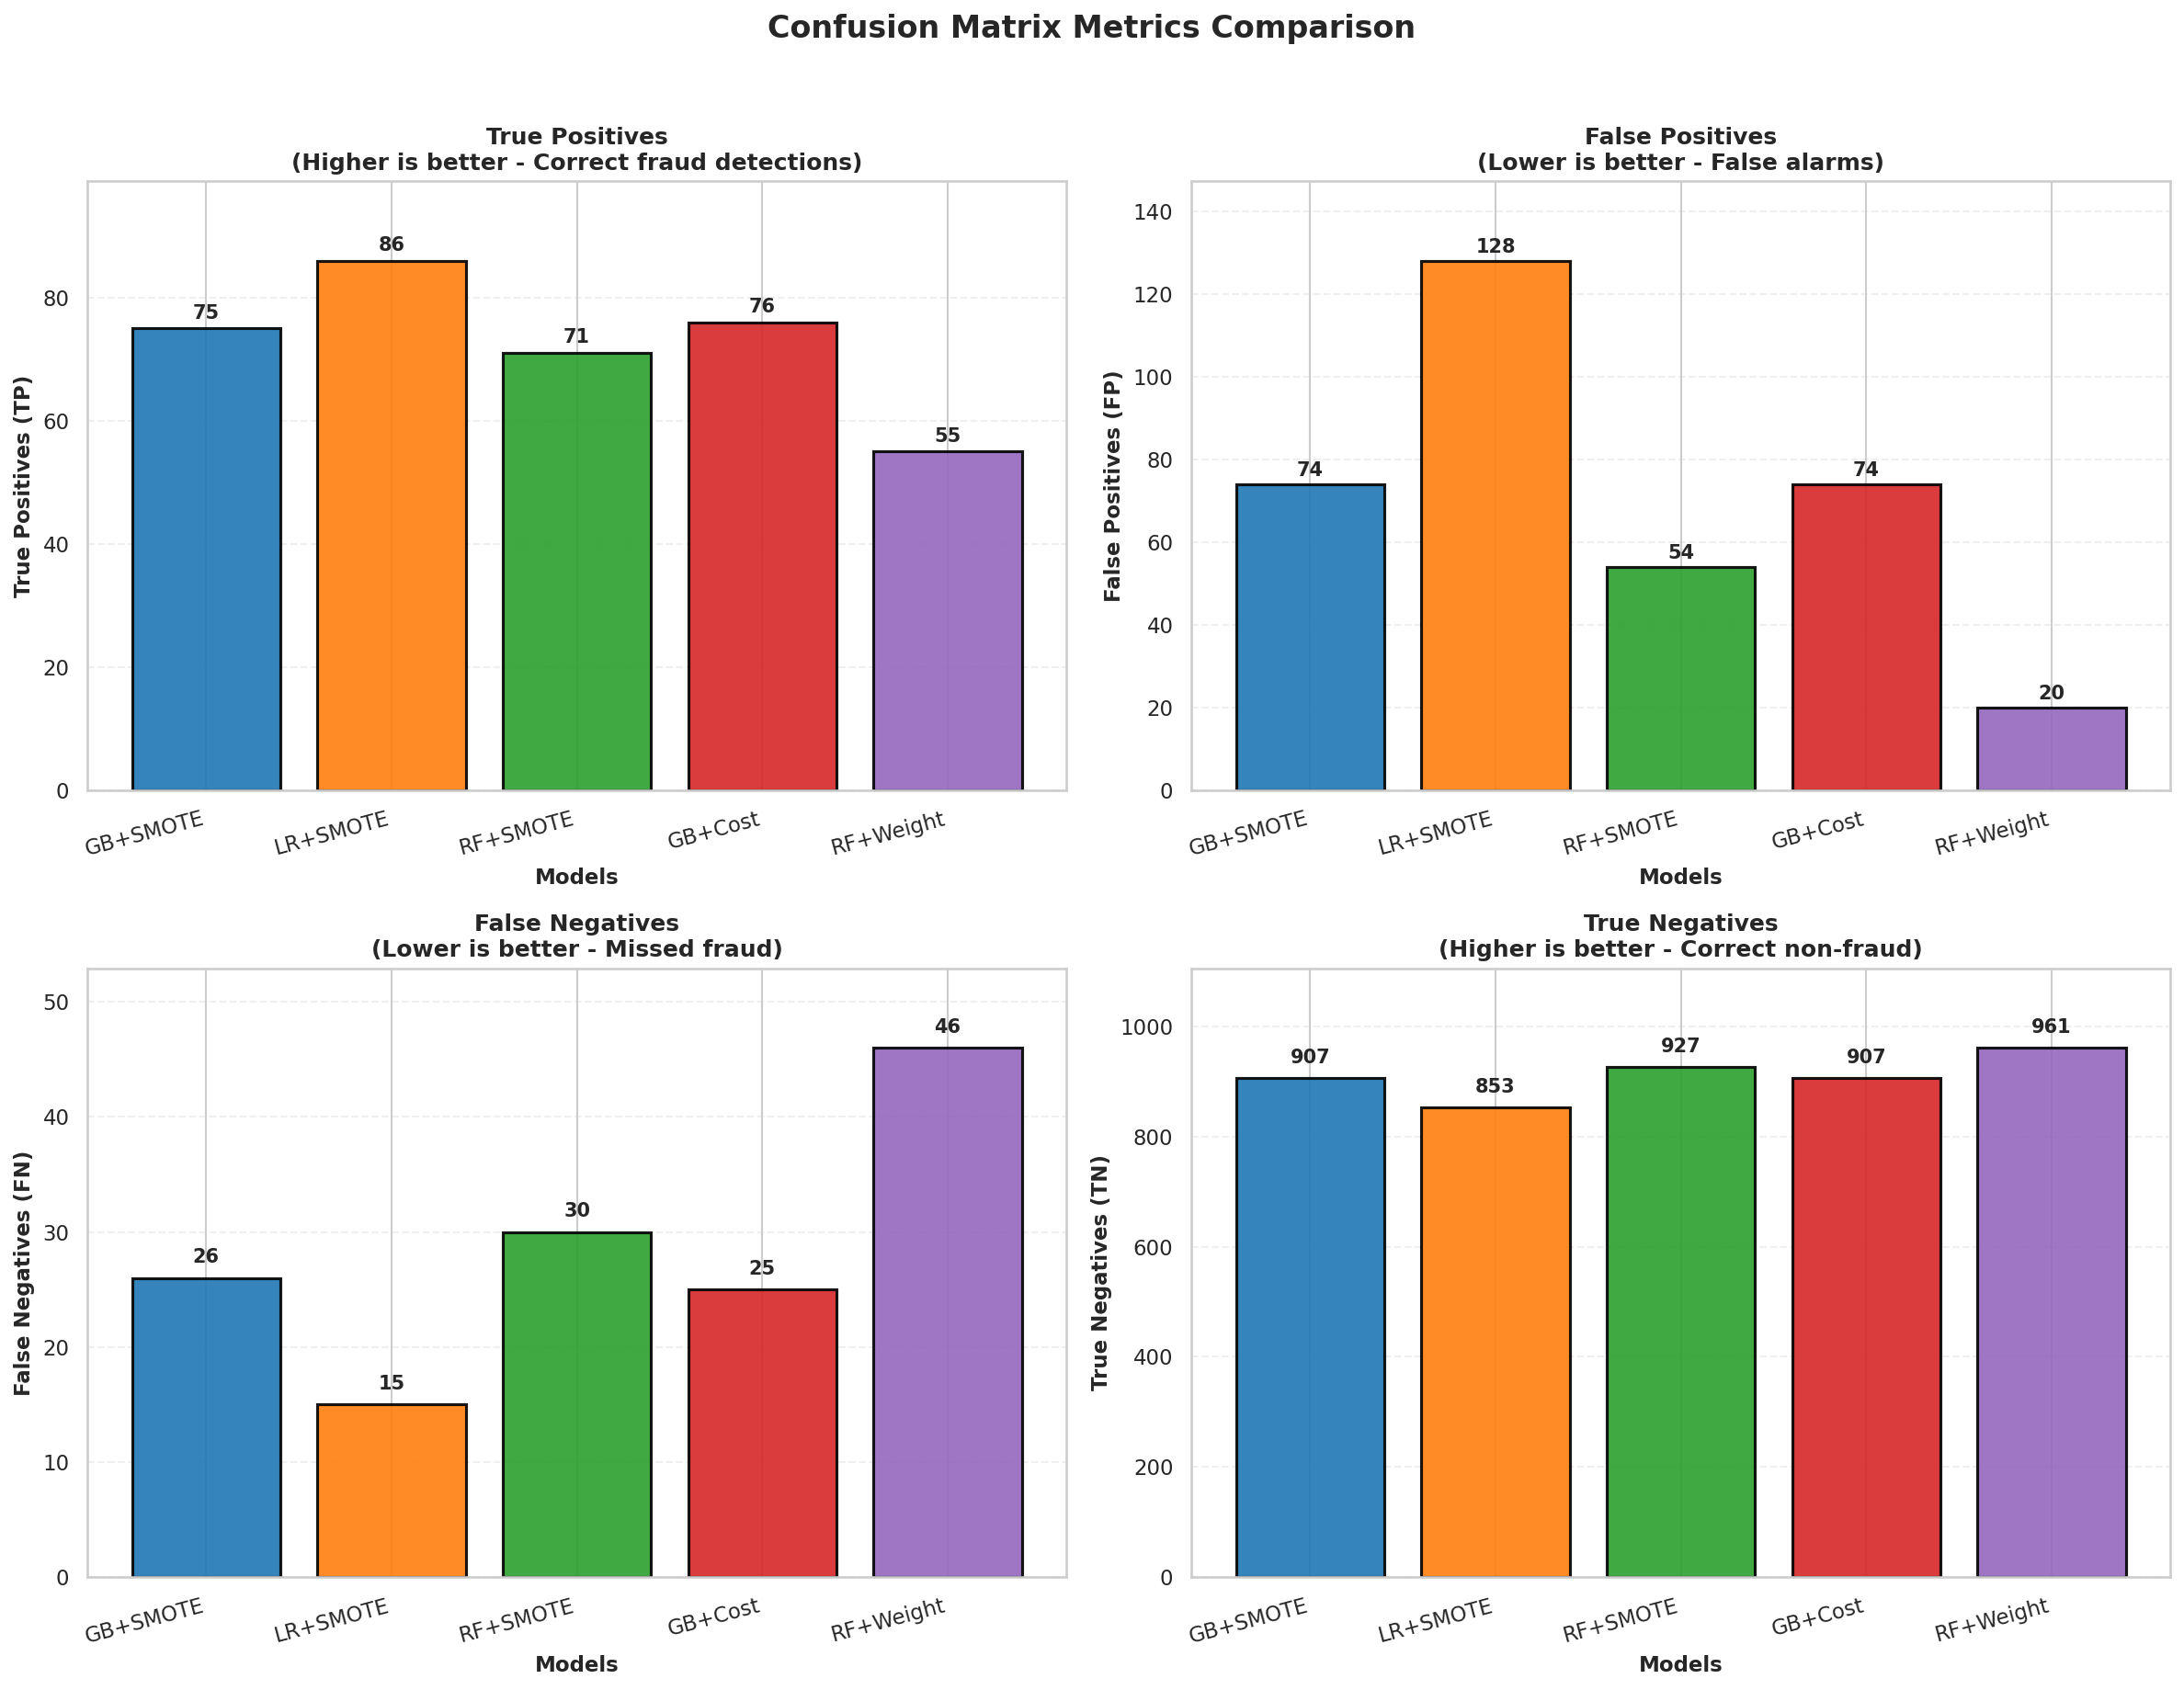


CONFUSION MATRIX METRICS ANALYSIS
Model           TP     FP     FN     TN     TP/FP    Recall   Precision 
--------------------------------------------------------------------------------
GB+SMOTE        75     74     26     907    1.01     0.7426   0.5034    
LR+SMOTE        86     128    15     853    0.67     0.8515   0.4019    
RF+SMOTE        71     54     30     927    1.31     0.7030   0.5680    
GB+Cost         76     74     25     907    1.03     0.7525   0.5067    
RF+Weight       55     20     46     961    2.75     0.5446   0.7333    

BUSINESS INTERPRETATION

GB+SMOTE:
  • Catches 74.3% of fraud cases (75/101)
  • 50.3% of fraud alarms are correct (75/149)
  • 74 false alarms, 26 missed fraud cases
  → GOOD at catching fraud
  → Moderate false alarms

LR+SMOTE:
  • Catches 85.1% of fraud cases (86/101)
  • 40.2% of fraud alarms are correct (86/214)
  • 128 false alarms, 15 missed fraud cases
  → EXCELLENT at catching fraud
  → Many false alarms

RF+SMOTE:
  • Catches 70.3

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your CSV file
df = pd.read_csv('/content/Machine_Learning_DataOrbit/reports/model_comparison_results_train_val_test_full.csv')

# Define model filters (adjust based on your actual CSV)
model_filters = {
    'GB+SMOTE': 'GradientBoosting__smote',
    'LR+SMOTE': 'LogisticRegression__smote',
    'RF+SMOTE': 'RandomForest__smote',
    'GB+Cost': 'GradientBoosting__cost_sensitive_sample_weight',
    'RF+Weight': 'RandomForest__class_weight'
}

# Initialize lists to store data
models = []
tp_values = []
fp_values = []
fn_values = []
tn_values = []

# Extract data for each model
for display_name, model_pattern in model_filters.items():
    # Find the row for this model (assuming dataset='val')
    model_data = df[(df['model'].str.contains(model_pattern)) & (df['dataset'] == 'val')]

    if not model_data.empty:
        models.append(display_name)
        tp_values.append(int(model_data['tp'].iloc[0]))
        fp_values.append(int(model_data['fp'].iloc[0]))
        fn_values.append(int(model_data['fn'].iloc[0]))
        tn_values.append(int(model_data['tn'].iloc[0]))
        print(f"Loaded {display_name}: TP={tp_values[-1]}, FP={fp_values[-1]}, FN={fn_values[-1]}, TN={tn_values[-1]}")
    else:
        print(f"Warning: Could not find data for {display_name}")

# Create a 2x2 grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confusion Matrix Metrics Comparison', fontsize=16, fontweight='bold', y=1.02)

# Colors for each model (consistent across all charts)
model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. TRUE POSITIVES (TP) Chart
ax1 = axes[0, 0]
tp_bars = ax1.bar(models, tp_values, color=model_colors, edgecolor='black', linewidth=1.5, alpha=0.9)
ax1.set_xlabel('Models', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Positives (TP)', fontsize=11, fontweight='bold')
ax1.set_title('True Positives\n(Higher is better - Correct fraud detections)', fontsize=12, fontweight='bold')
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(tp_values) * 1.15)

# Add value labels
for bar, value in zip(tp_bars, tp_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. FALSE POSITIVES (FP) Chart
ax2 = axes[0, 1]
fp_bars = ax2.bar(models, fp_values, color=model_colors, edgecolor='black', linewidth=1.5, alpha=0.9)
ax2.set_xlabel('Models', fontsize=11, fontweight='bold')
ax2.set_ylabel('False Positives (FP)', fontsize=11, fontweight='bold')
ax2.set_title('False Positives\n(Lower is better - False alarms)', fontsize=12, fontweight='bold')
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(fp_values) * 1.15)

# Add value labels
for bar, value in zip(fp_bars, fp_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. FALSE NEGATIVES (FN) Chart
ax3 = axes[1, 0]
fn_bars = ax3.bar(models, fn_values, color=model_colors, edgecolor='black', linewidth=1.5, alpha=0.9)
ax3.set_xlabel('Models', fontsize=11, fontweight='bold')
ax3.set_ylabel('False Negatives (FN)', fontsize=11, fontweight='bold')
ax3.set_title('False Negatives\n(Lower is better - Missed fraud)', fontsize=12, fontweight='bold')
ax3.set_xticklabels(models, rotation=15, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim(0, max(fn_values) * 1.15)

# Add value labels
for bar, value in zip(fn_bars, fn_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. TRUE NEGATIVES (TN) Chart
ax4 = axes[1, 1]
tn_bars = ax4.bar(models, tn_values, color=model_colors, edgecolor='black', linewidth=1.5, alpha=0.9)
ax4.set_xlabel('Models', fontsize=11, fontweight='bold')
ax4.set_ylabel('True Negatives (TN)', fontsize=11, fontweight='bold')
ax4.set_title('True Negatives\n(Higher is better - Correct non-fraud)', fontsize=12, fontweight='bold')
ax4.set_xticklabels(models, rotation=15, ha='right')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim(0, max(tn_values) * 1.15)

# Add value labels
for bar, value in zip(tn_bars, tn_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("CONFUSION MATRIX METRICS ANALYSIS")
print("="*80)
print(f"{'Model':<15} {'TP':<6} {'FP':<6} {'FN':<6} {'TN':<6} {'TP/FP':<8} {'Recall':<8} {'Precision':<10}")
print("-"*80)

for i, model in enumerate(models):
    # Calculate metrics
    recall = tp_values[i] / (tp_values[i] + fn_values[i]) if (tp_values[i] + fn_values[i]) > 0 else 0
    precision = tp_values[i] / (tp_values[i] + fp_values[i]) if (tp_values[i] + fp_values[i]) > 0 else 0
    tp_fp_ratio = tp_values[i] / fp_values[i] if fp_values[i] > 0 else float('inf')

    print(f"{model:<15} {tp_values[i]:<6} {fp_values[i]:<6} {fn_values[i]:<6} {tn_values[i]:<6} {tp_fp_ratio:<8.2f} {recall:<8.4f} {precision:<10.4f}")

print("="*80)

# Business interpretation
print("\n" + "="*80)
print("BUSINESS INTERPRETATION")
print("="*80)

for i, model in enumerate(models):
    recall = tp_values[i] / (tp_values[i] + fn_values[i]) if (tp_values[i] + fn_values[i]) > 0 else 0
    precision = tp_values[i] / (tp_values[i] + fp_values[i]) if (tp_values[i] + fp_values[i]) > 0 else 0

    print(f"\n{model}:")
    print(f"  • Catches {recall*100:.1f}% of fraud cases ({tp_values[i]}/{tp_values[i]+fn_values[i]})")
    print(f"  • {precision*100:.1f}% of fraud alarms are correct ({tp_values[i]}/{tp_values[i]+fp_values[i]})")
    print(f"  • {fp_values[i]} false alarms, {fn_values[i]} missed fraud cases")

    if recall > 0.8:
        print("  → EXCELLENT at catching fraud")
    elif recall > 0.7:
        print("  → GOOD at catching fraud")
    elif recall > 0.6:
        print("  → FAIR at catching fraud")
    else:
        print("  → POOR at catching fraud")

    if fp_values[i] < 30:
        print("  → Few false alarms")
    elif fp_values[i] < 80:
        print("  → Moderate false alarms")
    else:
        print("  → Many false alarms")

print("\n" + "="*80)
print("RECOMMENDATIONS:")
print("="*80)
print("• Choose LR+SMOTE if catching fraud is critical (85% recall)")
print("• Choose RF+Weight if minimizing false alarms is critical (only 20 FPs)")
print("• Choose GB+Cost or GB+SMOTE for balanced performance")
print("• RF+SMOTE offers good balance with reasonable FPs (54)")
print("="*80)